# Exercise Sheet 1 - CIFAR, MLP, Overfitting and Regularization

 * Deep Learning for Computer Vision – Winter Term 2024/25
 * Lecture by: Constantin Pape
 * Tutors: Anwai Archit, Oleg Bakumenko, Luca Freckmann, Marei Freitag, Sarah Muth, Sushmita Nair
 * Due date: **Tuesday, Nov 5, before 10:00**


## Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**


## Topic

In this exercise sheet, you will:
- get to know a new dataset: CIFAR-10
- implement a MLP
- get more familiar with model fitting
- see overfitting
- implement early stopping
- explore hyperparameters and their influence
- vary architecture to improve model performance

*We are looking forward to seeing your solutions! Have fun!*


## IMPORTANT SUBMISSION INSTRUCTIONS

- **You need to answer all questions in written form!**
- When you've completed the exercise, download the notebook and rename it to `<surname1>_<surname2>_<surname3>.ipynb`
- Only submit the Jupyter Notebook (.ipynb file). No other file is required.
    - Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 1`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- You have to present the exercise in the tutorials. We have a high ratio of students to tutors, so please decide which team member presents which part beforehand

Implementation:
- Do not change the cells which are marked as `DO NOT CHANGE`, similarly write your solution into the cells marked with TODOs for the questions asked.

### How to work on the exercise?
You will need access to a machine with a GPU to properly work on the exercises. We recommend using [Kaggle](https://www.kaggle.com/), which offers convenient access to a GPU and has all the dependencies that we need preinstalled ([here](https://gist.github.com/anwai98/444d3ff11c1365f2c610579d5df0830b) are the initial steps to work the Kaggle Notebooks). You can load this notebook on kaggle via `File` -> `Import Notebook` -> `Browse Files` and `Import`

## Introduction

In this task you will build a multi layer perceptron (MLP) model with PyTorch and perform training and prediction on the CIFAR dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:
- [PyTorch tutorial](https://pytorch.org/tutorials/)
- [Seaborn tutorial](https://seaborn.pydata.org/tutorial.html)

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [2]:
import os
import time
import pathlib
import fastprogress

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

### GPU and CUDA checks

Let's perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(False, True, 0)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Click the bottom-right corner menu `<` -> `Notebook options` -> `Accelerator` -> Select `GPU P100` as Hardware accelerator.

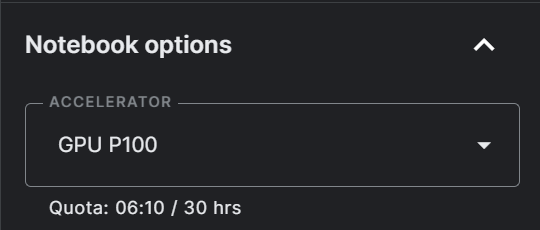

Now check the availability again (you would have to re-run the imports)

In [4]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(False, True, 0)

In [5]:
# DO NOT CHANGE
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print(
        'cuda available:', torch.cuda.is_available(), 
        '; cudnn available:', torch.backends.cudnn.is_available(),
        '; num devices:', torch.cuda.device_count()
    )
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [6]:
# DO NOT CHANGE
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: False ; cudnn available: True ; num devices: 0
Using device cpu
48 CPUs available


## Deep Learning with PyTorch

The process of training and evaluating a deep learning model begins with data loading. A dataset needs to be chosen on which the model should be trained. This data might need some preprocessing (like resizing or normalizing) of images. Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function. An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The model fitting is split into training and evaluation. In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction. The loss compares the prediction with the ground truth. In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step. In the evaluation process the loss is computed on the entire validation set. This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting. The model fitting process is repeated for N epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.

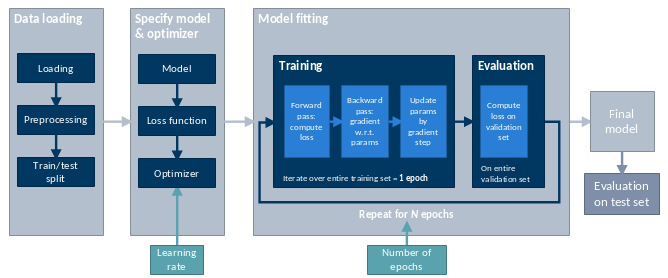

## Data Loading

## CIFAR dataset

This dataset contains natural images, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across it later to learn other concepts.

The first thing you should do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties. Feel free to visualize the images to have a better understanding.

**Download** the CIFAR dataset using torchvision dataset classes.

In [7]:
# DO NOT CHANGE
data_dir = pathlib.Path("data/")
cifar = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

Files already downloaded and verified


Let's check the first sample to see what it looks like

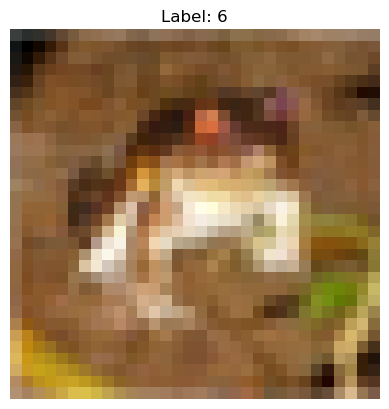

In [8]:
X_sample, y_sample = cifar[0]
# TODO: display the label and the image
plt.imshow(X_sample)
plt.title(f"Label: {y_sample}")
plt.axis('off')
plt.show()

Look at the types of X and y.

In [9]:
# TODO: display types
print(type(X_sample))
print(type(y_sample))

<class 'PIL.Image.Image'>
<class 'int'>


In [10]:
# TODO: display types
print(type(X_sample))
print(type(y_sample))

<class 'PIL.Image.Image'>
<class 'int'>


In [11]:
# TODO: print out the length of the dataset
print('Length of the dataset:', len(cifar))

Length of the dataset: 50000


In [12]:
# TODO: print out the length of the dataset
print('Length of the dataset:', len(cifar))

Length of the dataset: 50000


In [13]:
# DO NOT CHANGE
def grab_data(data_dir, num_cpus=10):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(
        data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()
    )

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=num_samples, num_workers=num_cpus
    )
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=True, transform=normalized_transform
    )

    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=False, transform=normalized_transform
    )

    return trainset, testset, dataset_mean, dataset_std

In [14]:
# DO NOT CHANGE
def grab_data(data_dir, num_cpus=10):
    """Downloads CIFAR10 train and test set, stores them on disk, computes mean 
        and standard deviation per channel of trainset, normalizes the train set
        accordingly.

    Args:
        data_dir (str): Directory to store data
        num_cpus (int, optional): Number of cpus that should be used to 
            preprocess data. Defaults to 1.

    Returns:
        CIFAR10, CIFAR10, float, float: Returns trainset and testset as
            torchvision CIFAR10 dataset objects. Returns mean and standard
            deviation used for normalization.
    """
    trainset = torchvision.datasets.CIFAR10(
        data_dir, train=True, download=True, transform=torchvision.transforms.ToTensor()
    )

    # Get normalization transform
    num_samples = trainset.data.shape[0]
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=num_samples, num_workers=num_cpus
    )
    imgs, _ = next(iter(trainloader))
    dataset_mean = torch.mean(imgs, dim=(0,2,3))
    dataset_std = torch.std(imgs, dim=(0,2,3))

    normalized_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(dataset_mean, dataset_std)
    ])

    # Load again, now normalized
    trainset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=True, transform=normalized_transform
    )

    # Apply the same transform, computed from the train-set, to the test-set
    # so both have a similar distribution. We do not normalize the test-set directly,
    # since we are not allowed to perform any computations with it. (We only use it
    # for reporting results in the very end)
    testset = torchvision.datasets.CIFAR10(
        data_dir, download=True, train=False, transform=normalized_transform
    )

    return trainset, testset, dataset_mean, dataset_std

In [15]:
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(
        trainset, (num_train_samples, num_val_samples), generator=torch.Generator().manual_seed(split_seed)
    )
    return trainset, valset

In [16]:
def generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2):
    """Splits train dataset into train and validation dataset.

    Args:
        trainset (CIFAR10): CIFAR10 trainset object
        split_seed (int, optional): Seed used to randomly assign data
            points to the validation set. Defaults to 42.
        val_frac (float, optional): Fraction of training set that should be 
            split into validation set. Defaults to 0.2.

    Returns:
        CIFAR10, CIFAR10: CIFAR10 trainset and validation set.
    """
    num_val_samples = np.ceil(val_frac * trainset.data.shape[0]).astype(int)
    num_train_samples = trainset.data.shape[0] - num_val_samples
    trainset, valset = torch.utils.data.random_split(
        trainset, (num_train_samples, num_val_samples), generator=torch.Generator().manual_seed(split_seed)
    )
    return trainset, valset

In [17]:
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=10):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )

    return trainloader, valloader, testloader

In [18]:
def init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=10):
    """Initialize train, validation and test data loader.

    Args:
        trainset (CIFAR10): Training set torchvision dataset object.
        valset (CIFAR10): Validation set torchvision dataset object.
        testset (CIFAR10): Test set torchvision dataset object.
        batch_size (int, optional): Batchsize that should be generated by 
            pytorch dataloader object. Defaults to 1024.
        num_cpus (int, optional): Number of CPUs to use when iterating over
            the data loader. More is faster. Defaults to 1.

    Returns:
        DataLoader, DataLoader, DataLoader: Returns pytorch DataLoader objects
            for training, validation and testing.
    """
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    valloader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True, num_workers=num_cpus
    )

    return trainloader, valloader, testloader

In [19]:
####################
trainset, testset, dataset_mean, dataset_std = grab_data(data_dir, num_cpus=10)
print('length of training set:', len(trainset))
print('length of test set:', len(testset))
print('mean:', dataset_mean)
print('std:', dataset_std)

trainset, valset = generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
print('trainset size:', len(trainset))
print('valset size:', len(valset))

trainloader, valloader, testloader = init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=10)
####################

Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified
length of training set: 50000
length of test set: 10000
mean: tensor([0.4914, 0.4822, 0.4465])
std: tensor([0.2470, 0.2435, 0.2616])
trainset size: 40000
valset size: 10000


Let's have a look at the dataset.

#### TODO
- Print all the class names
- Plot 16 images randomly drawn from the training set with their according class label

*Hint:* Since you normalized the dataset before, you have to undo that operation for plotting

In [20]:
def imshow(img, mean, std):
    """Undo normalization using mean and standard deviation and show image.

    Args:
        img (torch.Tensor): Image to show
        mean (np.array shape (3,)): Vector of means per channel used to
            normalize the dataset.
        std (np.array shape (3,)): Vector of standard deviations per channel 
            used to normalize the dataset.
    """
    # Define function to plot
    
    ####################
    # Undo normalization (broadcasting used to match dimensions)
    img = img * std[:, None, None] + mean[:, None, None]
    # Change the order of dimensions for plotting [H, W, C]
    img = img.permute(1, 2, 0)
    # Plot the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    ####################

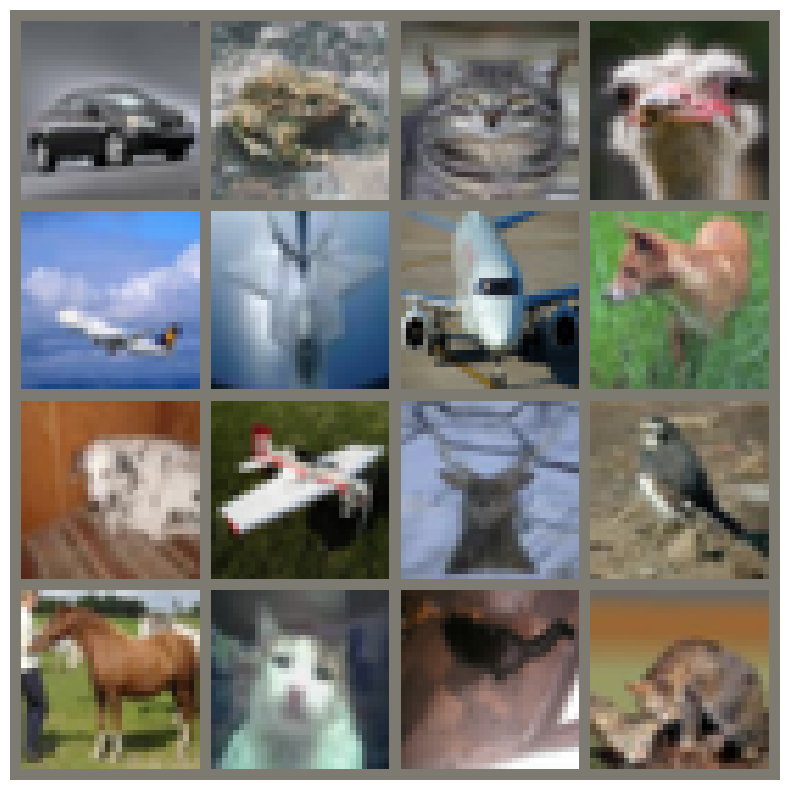

Image 1: automobile
Image 2: frog
Image 3: cat
Image 4: bird
Image 5: airplane
Image 6: airplane
Image 7: airplane
Image 8: dog
Image 9: dog
Image 10: airplane
Image 11: deer
Image 12: bird
Image 13: horse
Image 14: cat
Image 15: cat
Image 16: cat


In [21]:
import random
import torchvision.utils
# Define class names
class_names = cifar.classes

# Randomly selecting 16 images from the training set
random_indices = random.sample(range(len(trainset)), 16)
images = [trainset[i][0] for i in random_indices]
labels = [trainset[i][1] for i in random_indices]


# Create a grid of images
grid_img = torchvision.utils.make_grid(images, nrow=4, padding=2)

plt.figure(figsize=(10,10))

# Plot the images with their corresponding class labels
imshow(grid_img, dataset_mean, dataset_std)

# Print the class labels 
for i, label in enumerate(labels):
    print(f"Image {i+1}: {class_names[label]}")

# Hint: Use `torchvision.utils.make_grid`.

## Training, evaluation and plotting functions

Here, we provide examples of training, evaluation and plotting functions. Some parts are still missing. You can ignore this for the time being and move to the next section "**MLP Model**". You will implement the missing parts of these functions when required in the next sections.

In [22]:
def accuracy(correct, total): 
    """Compute accuracy as percentage.

    Args:
        correct (int): Number of samples correctly predicted.
        total (int): Total number of samples

    Returns:
        float: Accuracy
    """
    return float(correct)/total


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        # Zero the gradients for this batch to avoid accumulation of gradients 
        optimizer.zero_grad()
        model.train()

        # Forward pass (make a prediction on the training set)
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw 
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set, 
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    
    # Set model to evaluation mode 
    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] +=1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix


def run_training(
    model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader, early_stopper=None, verbose=False
):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data
        early_stopper (EarlyStopper, optional): If passed, model will be trained
            with early stopping. Defaults to None.
        verbose (bool, optional): Print information about model training. 
            Defaults to False.

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    # Initialize progress bar for epochs 
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(
            train_dataloader, optimizer, model, loss_function, device, master_bar
        )
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(
            val_dataloader, model, loss_function, device, master_bar
        )

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        # Print information about training progress 
        if verbose:
            master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')
        
        # Check if early stopping should be applied    
        if early_stopper:
            ####################
            # Update early stopper with the current validation loss
            early_stopper(epoch_val_loss, model)
            # Check if early stopping criterion is met 
            if early_stopper.early_stop:
                print("Early stopping")
                # Break training loop to stop training 
                break            
            ####################

            #raise NotImplementedError # Comment out this keyword after your implementation

            # END OF YOUR CODE #
            
    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix


def plot(
    title, label, train_results, val_results, yscale='linear', save_path=None, extra_pt=None, extra_pt_label=None
):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): x-axis label
        train_results (list): Results vector of training of length of number
            of epochs trained. Could be loss or accuracy.
        val_results (list): Results vector of validation of length of number
            of epochs. Could be loss or accuracy.
        yscale (str, optional): Matplotlib.pyplot.yscale parameter. 
            Defaults to 'linear'.
        save_path (str, optional): If passed, figure will be saved at this path.
            Defaults to None.
        extra_pt (tuple, optional): Tuple of length 2, defining x and y coordinate
            of where an additional black dot will be plotted. Defaults to None.
        extra_pt_label (str, optional): Legend label of extra point. Defaults to None.
    """
    
    epoch_array = np.arange(len(train_results)) + 1
    # Define legend labels for training and validation results 
    train_label, val_label = "Training "+label.lower(), "Validation "+label.lower()
    # Set seaborn style 
    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']
    
    if extra_pt:
        ####################
        # Plot the extra point 
        plot.plot(extra_pt[0], extra_pt[1], 'ko') # ko is black dot 
        # Add the extra point label to the legend 
        legend.append(extra_pt_label)
        ####################
        #raise NotImplementedError # Comment out this keyword after your implementation

        # END OF YOUR CODE #
        
    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    
    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    if save_path:
        plt.savefig(str(save_path), bbox_inches='tight')
    plt.show()

## MLP model

#### TODO
- Define an MLP model implementing all the functionality indicated by the parameters and the docstrings
- There should be a non-linearity after the input layer and in the hidden layers, i.e. in all layers that map to hidden units, but not in the final (linear) layer that creates the outputs

*Hint*: As CIFAR 10 contains color images, amongst other dimensions you want to flatten the color channel dimension, too.

In [24]:
class MLP(nn.Module):
    """Multi layer perceptron torch model."""
    def __init__(
        self, img_width, num_in_channels, num_classes, num_hidden_units=30, num_hidden_layers=1, act_fn=None
    ):
        """Initialize model.

        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            num_classes (int): Number of classes to predict
            num_hidden_units (int, optional): Number of hidden units per layer. 
                Defaults to 30.
            num_hidden_layers (int, optional): Number of hidden layers. Total
                number of layers will be num_hidden_layers + 2. Defaults to 1.
            act_fn (nn activation function, optional): Activation function
                to use after the first and all the hidden layers. If None, use
                nn.ReLU(). Defaults to None.
        """
        ####################
        # Initialize the parent class
        super(MLP, self).__init__()

        # Set the activation function to ReLU if not passed
        if act_fn is None:
            act_fn = nn.ReLU()
        self.act_fn = act_fn 

        # Calculate the number of input featuers to the first hidden layer 
        num_input_features = img_width * img_width * num_in_channels 

        # Define the input layer 
        self.input_layer = nn.Linear(num_input_features, num_hidden_units)

        # Define the hidden layers 
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_hidden_units, num_hidden_units))

        # Define the output layer 
        self.output_layer = nn.Linear(num_hidden_units, num_classes)
        ####################

    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        ####################
        # Flatten the input tensor 
        x = x.view(x.size(0), -1)

        # Pass the input tensor through the input layer 
        x = self.act_fn(self.input_layer(x))

        # Pass the input tensor through the hidden layers 
        for hidden_layer in self.hidden_layers:
            x = self.act_fn(hidden_layer(x))

        # Pass the input tensor through the output layer
        x = self.output_layer(x)

        return x 
        ####################


## Model training: learning rate

One of the most important hyperparameters is the learning rate. If we set it incorrectly, our model might not train at all, take very long time to train, or lead to suboptimal performance. Thus, we should make sure to set it appropriately.

So with what learning rate should we start? Usually, you would start setting a very high learning rate, e.g. ```lr = 1e0``` and then decrease it by a factor of ten until the model starts to converge. Since we might have to try multiple values here, it is sufficient to train only a few iterations to see if the model trains at all. As soon as we find a learning rate that works, we train for more epochs to get a well performing model.

For optimization, we use the commonly used Adam optimizer (not SGD), since it behaves very robustly and is easy to use.

#### TODO:
- Instantiate a MLP model with one hidden layer and ReLU activation function 
- Train the model for 10 epochs
- Use the Adam optimizer
- Start with a learning rate of $10^0$, then decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train
- Plot the training curves of the loss and the accuracies as in exercise 1. Use the functions defined above.

*Hints:*

**This is an example of a model that does not train sufficiently:** *(Why?)*

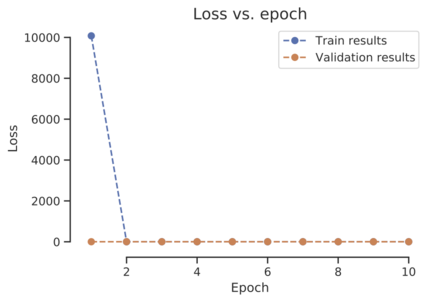

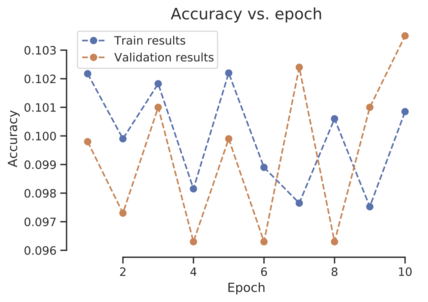

**This is an example of a model that does train:** *(Why?)*

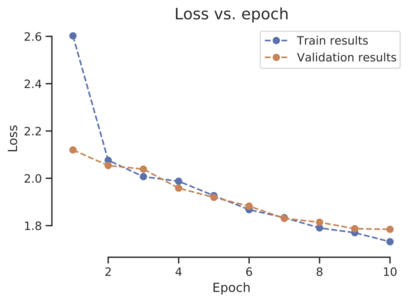

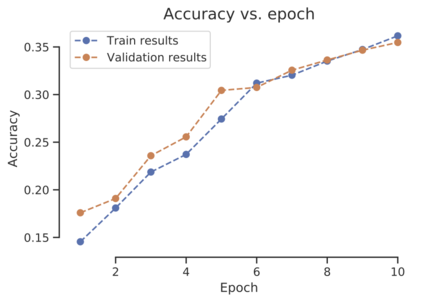

Learning rate: 0.0001, Epoch:1, Train loss: 2.25, Val loss: 2.17, Train acc: 0.141, Val acc: 0.223


Learning rate: 0.0001, Epoch:2, Train loss: 2.07, Val loss: 1.97, Train acc: 0.264, Val acc: 0.301


Learning rate: 0.0001, Epoch:3, Train loss: 1.89, Val loss: 1.84, Train acc: 0.321, Val acc: 0.353


Learning rate: 0.0001, Epoch:4, Train loss: 1.80, Val loss: 1.76, Train acc: 0.355, Val acc: 0.374


Learning rate: 0.0001, Epoch:5, Train loss: 1.73, Val loss: 1.71, Train acc: 0.383, Val acc: 0.393


Learning rate: 0.0001, Epoch:6, Train loss: 1.68, Val loss: 1.67, Train acc: 0.404, Val acc: 0.408


Learning rate: 0.0001, Epoch:7, Train loss: 1.64, Val loss: 1.64, Train acc: 0.421, Val acc: 0.417


Learning rate: 0.0001, Epoch:8, Train loss: 1.60, Val loss: 1.61, Train acc: 0.433, Val acc: 0.428


Learning rate: 0.0001, Epoch:9, Train loss: 1.57, Val loss: 1.59, Train acc: 0.444, Val acc: 0.439


Learning rate: 0.0001, Epoch:10, Train loss: 1.55, Val loss: 1.57, Train acc: 0.454, Val acc: 0.442


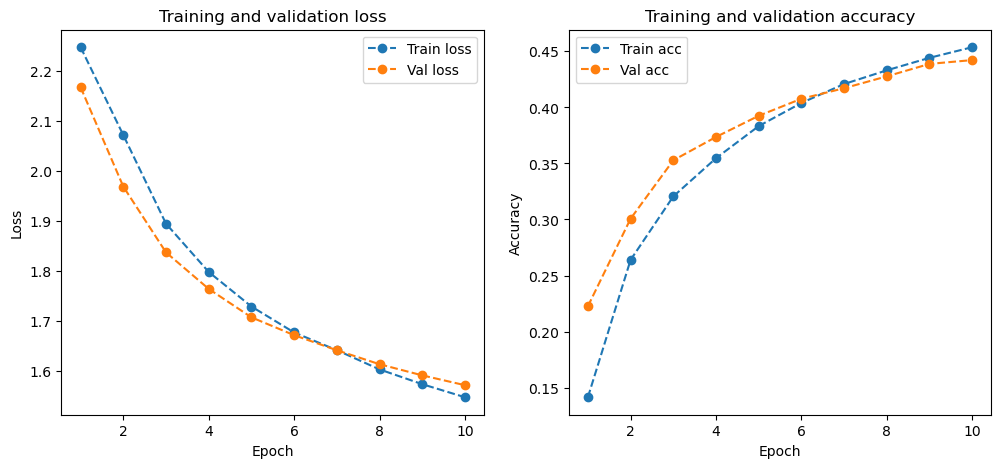

In [42]:
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    # if multiple GPUs are available
torch.backends.cudnn.deterministic = True   # if use cudnn
torch.backends.cudnn.benchmark = False       # benchmark mode may be faster for fixed size input, but may be slower for varying input sizes

# Instantiate the MLP model 
model = MLP(img_width = 32, num_in_channels = 3, num_classes = 10, num_hidden_units = 100, num_hidden_layers = 3, act_fn = nn.ReLU().to(device))

# Define the loss function 
loss_fn = nn.CrossEntropyLoss()

# Set the learning rate to 1 
learning_rate = 0.0001

# Store training and validation losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model for 10 epocs 
for epoch in range(1,11):
    train_loss, train_acc = train(trainloader, optimizer, model, loss_fn, device, None)
    val_loss, val_acc, _ = validate(valloader, model, loss_fn, device, None)

    # Store the losses and accuracies 
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Learning rate: {learning_rate}, Epoch:{epoch}, Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}, Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

# Plot the training and validaiton losses 
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,11), train_losses,'o--', label="Train loss")
plt.plot(range(1,11), val_losses, 'o--', label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()

# Plot the training and validation accuracies 
plt.subplot(1,2,2)
plt.plot(range(1,11), train_accuracies,'o--', label="Train acc")
plt.plot(range(1,11), val_accuracies, 'o--', label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()


Learning rate: 1, Epoch: 2, Train Loss: 3091.0194, Train Acc: 0.1013, Val Loss: 2.3188, Val Acc: 0.0999


Learning rate: 1, Epoch: 3, Train Loss: 2.3113, Train Acc: 0.0985, Val Loss: 2.3059, Val Acc: 0.0963


Learning rate: 1, Epoch: 4, Train Loss: 2.3068, Train Acc: 0.1014, Val Loss: 2.3088, Val Acc: 0.1025


Learning rate: 1, Epoch: 5, Train Loss: 2.3105, Train Acc: 0.0979, Val Loss: 2.3137, Val Acc: 0.1006


Learning rate: 1, Epoch: 6, Train Loss: 2.3127, Train Acc: 0.0973, Val Loss: 2.3190, Val Acc: 0.1010


Learning rate: 1, Epoch: 7, Train Loss: 2.3133, Train Acc: 0.0984, Val Loss: 2.3120, Val Acc: 0.0967


Learning rate: 1, Epoch: 8, Train Loss: 2.3108, Train Acc: 0.0999, Val Loss: 2.3097, Val Acc: 0.0963


Learning rate: 1, Epoch: 9, Train Loss: 2.3094, Train Acc: 0.0988, Val Loss: 2.3220, Val Acc: 0.0973


Learning rate: 1, Epoch: 10, Train Loss: 2.3149, Train Acc: 0.1014, Val Loss: 2.3216, Val Acc: 0.1025


Learning rate: 1, Epoch: 11, Train Loss: 2.3130, Train Acc: 0.0986, Val Loss: 2.3308, Val Acc: 0.0973


Learning rate: 0.1, Epoch: 2, Train Loss: 2.3073, Train Acc: 0.0976, Val Loss: 2.3054, Val Acc: 0.0967


Learning rate: 0.1, Epoch: 3, Train Loss: 2.3057, Train Acc: 0.1000, Val Loss: 2.3032, Val Acc: 0.1025


Learning rate: 0.1, Epoch: 4, Train Loss: 2.3041, Train Acc: 0.0992, Val Loss: 2.3061, Val Acc: 0.0973


Learning rate: 0.1, Epoch: 5, Train Loss: 2.3046, Train Acc: 0.1001, Val Loss: 2.3044, Val Acc: 0.1035


Learning rate: 0.1, Epoch: 6, Train Loss: 2.3050, Train Acc: 0.0981, Val Loss: 2.3048, Val Acc: 0.1025


Learning rate: 0.1, Epoch: 7, Train Loss: 2.3041, Train Acc: 0.0995, Val Loss: 2.3062, Val Acc: 0.0967


Learning rate: 0.1, Epoch: 8, Train Loss: 2.3048, Train Acc: 0.1022, Val Loss: 2.3041, Val Acc: 0.0973


Learning rate: 0.1, Epoch: 9, Train Loss: 2.3047, Train Acc: 0.1023, Val Loss: 2.3037, Val Acc: 0.1035


Learning rate: 0.1, Epoch: 10, Train Loss: 2.3041, Train Acc: 0.1027, Val Loss: 2.3039, Val Acc: 0.1006


Learning rate: 0.1, Epoch: 11, Train Loss: 2.3048, Train Acc: 0.0984, Val Loss: 2.3035, Val Acc: 0.0998


Learning rate: 0.01, Epoch: 2, Train Loss: 2.3031, Train Acc: 0.1003, Val Loss: 2.3027, Val Acc: 0.1010


Learning rate: 0.01, Epoch: 3, Train Loss: 2.3029, Train Acc: 0.0984, Val Loss: 2.3029, Val Acc: 0.0963


Learning rate: 0.01, Epoch: 4, Train Loss: 2.3028, Train Acc: 0.0989, Val Loss: 2.3027, Val Acc: 0.0967


Learning rate: 0.01, Epoch: 5, Train Loss: 2.3031, Train Acc: 0.0984, Val Loss: 2.3028, Val Acc: 0.0973


Learning rate: 0.01, Epoch: 6, Train Loss: 2.3028, Train Acc: 0.1008, Val Loss: 2.3028, Val Acc: 0.0963


Learning rate: 0.01, Epoch: 7, Train Loss: 2.3029, Train Acc: 0.0991, Val Loss: 2.3028, Val Acc: 0.0963


Learning rate: 0.01, Epoch: 8, Train Loss: 2.3029, Train Acc: 0.0972, Val Loss: 2.3027, Val Acc: 0.1010


Learning rate: 0.01, Epoch: 9, Train Loss: 2.3029, Train Acc: 0.0988, Val Loss: 2.3028, Val Acc: 0.0963


Learning rate: 0.01, Epoch: 10, Train Loss: 2.3029, Train Acc: 0.0977, Val Loss: 2.3031, Val Acc: 0.0963


Learning rate: 0.01, Epoch: 11, Train Loss: 2.3029, Train Acc: 0.0987, Val Loss: 2.3028, Val Acc: 0.1010


Learning rate: 0.001, Epoch: 2, Train Loss: 2.3026, Train Acc: 0.0996, Val Loss: 2.3027, Val Acc: 0.1010


Learning rate: 0.001, Epoch: 3, Train Loss: 2.3026, Train Acc: 0.0998, Val Loss: 2.3027, Val Acc: 0.1010


Learning rate: 0.001, Epoch: 4, Train Loss: 2.3026, Train Acc: 0.0995, Val Loss: 2.3027, Val Acc: 0.0967


Learning rate: 0.001, Epoch: 5, Train Loss: 2.3026, Train Acc: 0.1008, Val Loss: 2.3027, Val Acc: 0.0967


Learning rate: 0.001, Epoch: 6, Train Loss: 2.3026, Train Acc: 0.1008, Val Loss: 2.3027, Val Acc: 0.0967


Learning rate: 0.001, Epoch: 7, Train Loss: 2.3026, Train Acc: 0.1008, Val Loss: 2.3027, Val Acc: 0.0967


Learning rate: 0.001, Epoch: 8, Train Loss: 2.3026, Train Acc: 0.1000, Val Loss: 2.3028, Val Acc: 0.0963


Learning rate: 0.001, Epoch: 9, Train Loss: 2.3026, Train Acc: 0.0993, Val Loss: 2.3027, Val Acc: 0.0963


Learning rate: 0.001, Epoch: 10, Train Loss: 2.3026, Train Acc: 0.1009, Val Loss: 2.3027, Val Acc: 0.0963


Learning rate: 0.001, Epoch: 11, Train Loss: 2.3026, Train Acc: 0.1009, Val Loss: 2.3027, Val Acc: 0.0963


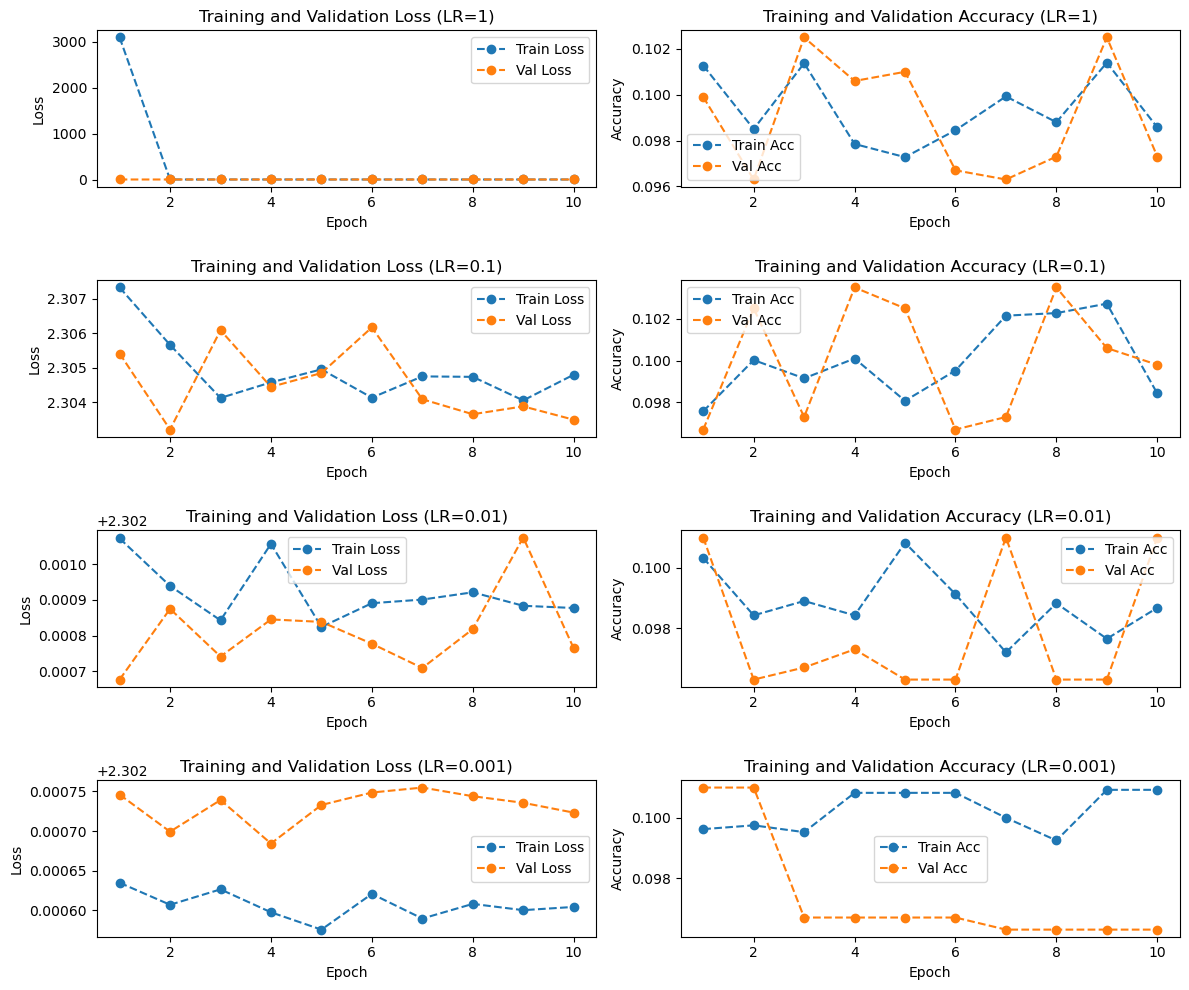

In [24]:
####################
# Instantiate the MLP model
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=30, num_hidden_layers=1, act_fn=nn.ReLU()).to(device)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the learning rates to try
learning_rates = [10**i for i in range(0, -4, -1)]

# Store the training and validation losses and accuracies for each learning rate
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Train the model for each learning rate
for lr in learning_rates:
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Store the training and validation losses and accuracies for the current learning rate
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Train the model
    for epoch in range(1,11):
        train_loss, train_acc = train(trainloader, optimizer, model, loss_fn, device, None)
        val_loss, val_acc, _ = validate(valloader, model, loss_fn, device, None)
        
        # Store the losses and accuracies
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Learning rate: {lr}, Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Append the results for the current learning rate to the overall lists
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(12, 10))
for i, lr in enumerate(learning_rates):
    plt.subplot(len(learning_rates), 2, 2*i+1)
    plt.plot(range(1, 11), all_train_losses[i], 'o--', label='Train Loss')
    plt.plot(range(1, 11), all_val_losses[i], 'o--', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (LR={lr})')
    plt.legend()

    plt.subplot(len(learning_rates), 2, 2*i+2)
    plt.plot(range(1, 11), all_train_accuracies[i], 'o--', label='Train Acc')
    plt.plot(range(1, 11), all_val_accuracies[i], 'o--', label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy (LR={lr})')
    plt.legend()

plt.tight_layout()
plt.show()
####################

Has your model already converged, i.e. reached the highest accuracy on the validation set? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs (this might take approx. 30 min depending on your GPU)

#### TODO from now on, for all subsequent tasks:
- Print the overall best value and the epoch at which it occurred of:
    - val loss and
    - val accuracy

In [26]:
####################
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    # if multiple GPUs are available
torch.backends.cudnn.deterministic = True   # if use cudnn
torch.backends.cudnn.benchmark = False       # benchmark mode may be faster for fixed size input, but may be slower for varying input sizes

# Instantiate the MLP model 
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=100, num_hidden_layers=3, act_fn=nn.ReLU()).to(device)

# Define the loss function 
loss_fn = nn.CrossEntropyLoss()

# Set the learning rate to 0.0001
learning_rate = 0.0001

# Store training and validation losses and accuracies 
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Define the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model for 100 epochs 

for epoch in range(1,101):
    train_loss, train_acc = train(trainloader, optimizer, model, loss_fn, device, None)
    val_loss, val_acc, _ = validate(valloader, model, loss_fn, device, None)

    # Store the losses and accuracies 
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Learning rate: {learning_rate}, Epoch: {epoch}, Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}, Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

# Find the best validation loss and accuracy 
best_val_loss = min(val_losses)
best_val_loss_epoch = val_losses.index(best_val_loss) + 1
best_val_acc = max(val_accuracies)
best_val_acc_epoch = val_accuracies.index(best_val_acc) + 1
print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")
####################

Learning rate: 0.0001, Epoch: 1, Train loss: 2.25, Val loss: 2.17, Train acc: 0.141, Val acc: 0.223


Learning rate: 0.0001, Epoch: 2, Train loss: 2.07, Val loss: 1.97, Train acc: 0.264, Val acc: 0.301


Learning rate: 0.0001, Epoch: 3, Train loss: 1.89, Val loss: 1.84, Train acc: 0.321, Val acc: 0.353


Learning rate: 0.0001, Epoch: 4, Train loss: 1.80, Val loss: 1.76, Train acc: 0.355, Val acc: 0.374


Learning rate: 0.0001, Epoch: 5, Train loss: 1.73, Val loss: 1.71, Train acc: 0.383, Val acc: 0.393


Learning rate: 0.0001, Epoch: 6, Train loss: 1.68, Val loss: 1.67, Train acc: 0.404, Val acc: 0.408


Learning rate: 0.0001, Epoch: 7, Train loss: 1.64, Val loss: 1.64, Train acc: 0.421, Val acc: 0.417


Learning rate: 0.0001, Epoch: 8, Train loss: 1.60, Val loss: 1.61, Train acc: 0.433, Val acc: 0.428


Learning rate: 0.0001, Epoch: 9, Train loss: 1.57, Val loss: 1.59, Train acc: 0.444, Val acc: 0.439


Learning rate: 0.0001, Epoch: 10, Train loss: 1.55, Val loss: 1.57, Train acc: 0.454, Val acc: 0.442


Learning rate: 0.0001, Epoch: 11, Train loss: 1.53, Val loss: 1.56, Train acc: 0.461, Val acc: 0.452


Learning rate: 0.0001, Epoch: 12, Train loss: 1.51, Val loss: 1.54, Train acc: 0.469, Val acc: 0.457


Learning rate: 0.0001, Epoch: 13, Train loss: 1.49, Val loss: 1.53, Train acc: 0.478, Val acc: 0.459


Learning rate: 0.0001, Epoch: 14, Train loss: 1.48, Val loss: 1.52, Train acc: 0.482, Val acc: 0.466


Learning rate: 0.0001, Epoch: 15, Train loss: 1.46, Val loss: 1.51, Train acc: 0.488, Val acc: 0.469


Learning rate: 0.0001, Epoch: 16, Train loss: 1.45, Val loss: 1.50, Train acc: 0.493, Val acc: 0.471


Learning rate: 0.0001, Epoch: 17, Train loss: 1.43, Val loss: 1.50, Train acc: 0.497, Val acc: 0.474


Learning rate: 0.0001, Epoch: 18, Train loss: 1.42, Val loss: 1.49, Train acc: 0.504, Val acc: 0.475


Learning rate: 0.0001, Epoch: 19, Train loss: 1.40, Val loss: 1.48, Train acc: 0.506, Val acc: 0.478


Learning rate: 0.0001, Epoch: 20, Train loss: 1.39, Val loss: 1.47, Train acc: 0.511, Val acc: 0.477


Learning rate: 0.0001, Epoch: 21, Train loss: 1.38, Val loss: 1.47, Train acc: 0.514, Val acc: 0.481


Learning rate: 0.0001, Epoch: 22, Train loss: 1.37, Val loss: 1.47, Train acc: 0.518, Val acc: 0.481


Learning rate: 0.0001, Epoch: 23, Train loss: 1.35, Val loss: 1.46, Train acc: 0.523, Val acc: 0.486


Learning rate: 0.0001, Epoch: 24, Train loss: 1.34, Val loss: 1.45, Train acc: 0.526, Val acc: 0.485


Learning rate: 0.0001, Epoch: 25, Train loss: 1.34, Val loss: 1.45, Train acc: 0.531, Val acc: 0.491


Learning rate: 0.0001, Epoch: 26, Train loss: 1.32, Val loss: 1.44, Train acc: 0.535, Val acc: 0.494


Learning rate: 0.0001, Epoch: 27, Train loss: 1.31, Val loss: 1.44, Train acc: 0.537, Val acc: 0.494


Learning rate: 0.0001, Epoch: 28, Train loss: 1.30, Val loss: 1.44, Train acc: 0.541, Val acc: 0.496


Learning rate: 0.0001, Epoch: 29, Train loss: 1.30, Val loss: 1.44, Train acc: 0.543, Val acc: 0.495


Learning rate: 0.0001, Epoch: 30, Train loss: 1.28, Val loss: 1.43, Train acc: 0.546, Val acc: 0.499


Learning rate: 0.0001, Epoch: 31, Train loss: 1.26, Val loss: 1.42, Train acc: 0.550, Val acc: 0.498


Learning rate: 0.0001, Epoch: 32, Train loss: 1.26, Val loss: 1.43, Train acc: 0.555, Val acc: 0.499


Learning rate: 0.0001, Epoch: 33, Train loss: 1.25, Val loss: 1.43, Train acc: 0.557, Val acc: 0.499


Learning rate: 0.0001, Epoch: 34, Train loss: 1.24, Val loss: 1.42, Train acc: 0.561, Val acc: 0.501


Learning rate: 0.0001, Epoch: 35, Train loss: 1.24, Val loss: 1.42, Train acc: 0.565, Val acc: 0.502


Learning rate: 0.0001, Epoch: 36, Train loss: 1.23, Val loss: 1.42, Train acc: 0.566, Val acc: 0.503


Learning rate: 0.0001, Epoch: 37, Train loss: 1.23, Val loss: 1.42, Train acc: 0.569, Val acc: 0.505


Learning rate: 0.0001, Epoch: 38, Train loss: 1.21, Val loss: 1.41, Train acc: 0.572, Val acc: 0.502


Learning rate: 0.0001, Epoch: 39, Train loss: 1.20, Val loss: 1.41, Train acc: 0.577, Val acc: 0.505


Learning rate: 0.0001, Epoch: 40, Train loss: 1.19, Val loss: 1.41, Train acc: 0.579, Val acc: 0.506


Learning rate: 0.0001, Epoch: 41, Train loss: 1.18, Val loss: 1.41, Train acc: 0.583, Val acc: 0.507


Learning rate: 0.0001, Epoch: 42, Train loss: 1.18, Val loss: 1.41, Train acc: 0.585, Val acc: 0.504


Learning rate: 0.0001, Epoch: 43, Train loss: 1.17, Val loss: 1.42, Train acc: 0.588, Val acc: 0.503


Learning rate: 0.0001, Epoch: 44, Train loss: 1.16, Val loss: 1.41, Train acc: 0.592, Val acc: 0.510


Learning rate: 0.0001, Epoch: 45, Train loss: 1.15, Val loss: 1.41, Train acc: 0.593, Val acc: 0.509


Learning rate: 0.0001, Epoch: 46, Train loss: 1.15, Val loss: 1.41, Train acc: 0.596, Val acc: 0.509


Learning rate: 0.0001, Epoch: 47, Train loss: 1.14, Val loss: 1.41, Train acc: 0.598, Val acc: 0.510


Learning rate: 0.0001, Epoch: 48, Train loss: 1.13, Val loss: 1.41, Train acc: 0.600, Val acc: 0.511


Learning rate: 0.0001, Epoch: 49, Train loss: 1.13, Val loss: 1.41, Train acc: 0.604, Val acc: 0.508


Learning rate: 0.0001, Epoch: 50, Train loss: 1.12, Val loss: 1.41, Train acc: 0.606, Val acc: 0.507


Learning rate: 0.0001, Epoch: 51, Train loss: 1.11, Val loss: 1.41, Train acc: 0.608, Val acc: 0.508


Learning rate: 0.0001, Epoch: 52, Train loss: 1.11, Val loss: 1.41, Train acc: 0.612, Val acc: 0.510


Learning rate: 0.0001, Epoch: 53, Train loss: 1.10, Val loss: 1.42, Train acc: 0.613, Val acc: 0.509


Learning rate: 0.0001, Epoch: 54, Train loss: 1.10, Val loss: 1.41, Train acc: 0.614, Val acc: 0.514


Learning rate: 0.0001, Epoch: 55, Train loss: 1.09, Val loss: 1.42, Train acc: 0.619, Val acc: 0.510


Learning rate: 0.0001, Epoch: 56, Train loss: 1.08, Val loss: 1.42, Train acc: 0.620, Val acc: 0.510


Learning rate: 0.0001, Epoch: 57, Train loss: 1.07, Val loss: 1.43, Train acc: 0.624, Val acc: 0.509


Learning rate: 0.0001, Epoch: 58, Train loss: 1.07, Val loss: 1.42, Train acc: 0.624, Val acc: 0.510


Learning rate: 0.0001, Epoch: 59, Train loss: 1.06, Val loss: 1.43, Train acc: 0.626, Val acc: 0.511


Learning rate: 0.0001, Epoch: 60, Train loss: 1.06, Val loss: 1.42, Train acc: 0.628, Val acc: 0.512


Learning rate: 0.0001, Epoch: 61, Train loss: 1.05, Val loss: 1.43, Train acc: 0.634, Val acc: 0.510


Learning rate: 0.0001, Epoch: 62, Train loss: 1.04, Val loss: 1.43, Train acc: 0.633, Val acc: 0.511


Learning rate: 0.0001, Epoch: 63, Train loss: 1.04, Val loss: 1.43, Train acc: 0.636, Val acc: 0.510


Learning rate: 0.0001, Epoch: 64, Train loss: 1.03, Val loss: 1.44, Train acc: 0.639, Val acc: 0.510


Learning rate: 0.0001, Epoch: 65, Train loss: 1.02, Val loss: 1.44, Train acc: 0.642, Val acc: 0.510


Learning rate: 0.0001, Epoch: 66, Train loss: 1.02, Val loss: 1.45, Train acc: 0.644, Val acc: 0.507


Learning rate: 0.0001, Epoch: 67, Train loss: 1.01, Val loss: 1.44, Train acc: 0.645, Val acc: 0.512


Learning rate: 0.0001, Epoch: 68, Train loss: 1.01, Val loss: 1.45, Train acc: 0.647, Val acc: 0.506


Learning rate: 0.0001, Epoch: 69, Train loss: 1.00, Val loss: 1.45, Train acc: 0.648, Val acc: 0.509


Learning rate: 0.0001, Epoch: 70, Train loss: 0.99, Val loss: 1.46, Train acc: 0.651, Val acc: 0.508


Learning rate: 0.0001, Epoch: 71, Train loss: 0.99, Val loss: 1.45, Train acc: 0.654, Val acc: 0.511


Learning rate: 0.0001, Epoch: 72, Train loss: 0.98, Val loss: 1.46, Train acc: 0.657, Val acc: 0.508


Learning rate: 0.0001, Epoch: 73, Train loss: 0.98, Val loss: 1.47, Train acc: 0.657, Val acc: 0.509


Learning rate: 0.0001, Epoch: 74, Train loss: 0.98, Val loss: 1.47, Train acc: 0.657, Val acc: 0.506


Learning rate: 0.0001, Epoch: 75, Train loss: 0.97, Val loss: 1.46, Train acc: 0.660, Val acc: 0.510


Learning rate: 0.0001, Epoch: 76, Train loss: 0.96, Val loss: 1.46, Train acc: 0.662, Val acc: 0.510


Learning rate: 0.0001, Epoch: 77, Train loss: 0.96, Val loss: 1.47, Train acc: 0.666, Val acc: 0.510


Learning rate: 0.0001, Epoch: 78, Train loss: 0.95, Val loss: 1.47, Train acc: 0.665, Val acc: 0.510


Learning rate: 0.0001, Epoch: 79, Train loss: 0.95, Val loss: 1.48, Train acc: 0.669, Val acc: 0.511


Learning rate: 0.0001, Epoch: 80, Train loss: 0.94, Val loss: 1.49, Train acc: 0.671, Val acc: 0.506


Learning rate: 0.0001, Epoch: 81, Train loss: 0.94, Val loss: 1.49, Train acc: 0.672, Val acc: 0.507


Learning rate: 0.0001, Epoch: 82, Train loss: 0.93, Val loss: 1.50, Train acc: 0.674, Val acc: 0.504


Learning rate: 0.0001, Epoch: 83, Train loss: 0.94, Val loss: 1.49, Train acc: 0.673, Val acc: 0.507


Learning rate: 0.0001, Epoch: 84, Train loss: 0.92, Val loss: 1.49, Train acc: 0.678, Val acc: 0.507


Learning rate: 0.0001, Epoch: 85, Train loss: 0.91, Val loss: 1.50, Train acc: 0.679, Val acc: 0.510


Learning rate: 0.0001, Epoch: 86, Train loss: 0.91, Val loss: 1.50, Train acc: 0.682, Val acc: 0.505


Learning rate: 0.0001, Epoch: 87, Train loss: 0.90, Val loss: 1.51, Train acc: 0.684, Val acc: 0.508


Learning rate: 0.0001, Epoch: 88, Train loss: 0.90, Val loss: 1.51, Train acc: 0.682, Val acc: 0.504


Learning rate: 0.0001, Epoch: 89, Train loss: 0.89, Val loss: 1.52, Train acc: 0.688, Val acc: 0.503


Learning rate: 0.0001, Epoch: 90, Train loss: 0.89, Val loss: 1.52, Train acc: 0.688, Val acc: 0.501


Learning rate: 0.0001, Epoch: 91, Train loss: 0.88, Val loss: 1.54, Train acc: 0.690, Val acc: 0.503


Learning rate: 0.0001, Epoch: 92, Train loss: 0.87, Val loss: 1.53, Train acc: 0.691, Val acc: 0.503


Learning rate: 0.0001, Epoch: 93, Train loss: 0.87, Val loss: 1.54, Train acc: 0.693, Val acc: 0.507


Learning rate: 0.0001, Epoch: 94, Train loss: 0.87, Val loss: 1.53, Train acc: 0.694, Val acc: 0.507


Learning rate: 0.0001, Epoch: 95, Train loss: 0.86, Val loss: 1.54, Train acc: 0.697, Val acc: 0.506


Learning rate: 0.0001, Epoch: 96, Train loss: 0.86, Val loss: 1.55, Train acc: 0.699, Val acc: 0.503


Learning rate: 0.0001, Epoch: 97, Train loss: 0.86, Val loss: 1.55, Train acc: 0.701, Val acc: 0.506


Learning rate: 0.0001, Epoch: 98, Train loss: 0.85, Val loss: 1.55, Train acc: 0.702, Val acc: 0.504


Learning rate: 0.0001, Epoch: 99, Train loss: 0.85, Val loss: 1.57, Train acc: 0.703, Val acc: 0.502


Learning rate: 0.0001, Epoch: 100, Train loss: 0.84, Val loss: 1.57, Train acc: 0.703, Val acc: 0.500
Best validation loss: 1.4055 at epoch 44
Best validation accuracy: 0.5139 at epoch 54


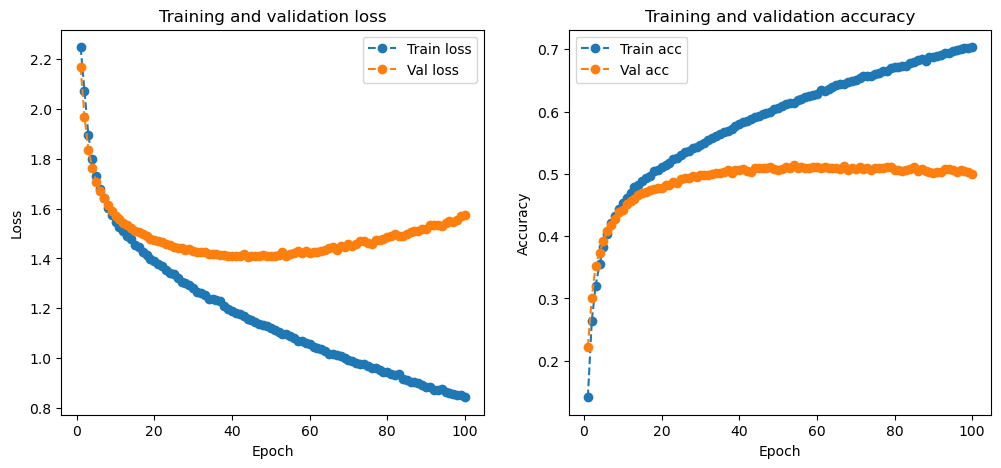

In [27]:
# Plot the training and validation losses 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), train_losses, 'o--', label="Train loss")
plt.plot(range(1, 101), val_losses, 'o--', label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()

# Plot the training and validation accuracies 
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), train_accuracies, 'o--', label="Train acc")
plt.plot(range(1, 101), val_accuracies, 'o--', label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()

Let's have a look at those training curves! Here are some questions for you.

#### TODO:
Answer the following questions in written form, as they are really crucial for the rest of this course.

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the minimum of the curves.)
1. Do the training and validation accuracy increase after each epoch? Why? // Why not?
1. Are the epochs at which you got the best validation loss and the best validation accuracy the same?
1. (Optional): Do you have any ideas why not?
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

#### Your answers:
1. The training loss generally decreases after each epoch because the model is learning from the training data. The optimizer adjusts the model parameters to minimize the loss function, which results in a decrease in training loss over time. However, there might be some fluctuations due to the stochastic nature of the optimization process.

2. Validation loss also decreases smoothly up to some point but then starts increasing, as its minimum value, 1.4055, happens at epoch 44. Some part of the fluctuations is because of the inherent variability and randomness of the process. It may decrease initially as the model learns useful patterns from the training data, but it can start to increase if the model begins to overfit the training data.
3. The training accuracy generally increases after each epoch because the model is learning to make better predictions on the training data while the validation accuracy stops after some point and plateaus as the model starts to overfit. The accuracy metrics are influenced by how well the model generalizes to unseen data.

4. No, Best validation loss: 1.4055 at epoch 44
Best validation accuracy: 0.5139 at epoch 54. 
5. The best validation loss and accuracy may not coincide because the loss function and accuracy metric measure different aspects of model performance. The loss function considers the confidence of predictions (look at the cross-entropy formula), while accuracy only considers whether predictions are correct. A model might have a lower loss but not the highest accuracy if it makes some confident but incorrect predictions.
6. The epoch where the validation loss is the minimum, as it indicates the best fit to the valiation data without overfitting. after that point the loss curves start diverging which shows the overfitting of the model. This model is likely to generalize better to unseen samples. Using the model from epoch 44, where the lowest validation loss occurred, helps avoid overfitting and ensures better performance on the test set.

## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO:
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Compute `model2`'s validation set accuracy. *Hint:* You can use the validation function from above. As a parameter, you would have to set `master_bar=None` since there is no progress bar for epochs in this setting.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation set accuracy again. It should be of the exact same value as `model`'s validation set accuracy.

*Hints:*
- Read https://pytorch.org/tutorials/beginner/saving_loading_models.html
- Use `model.state_dict()`

In [51]:
####################
# Save the model's state dictionary
torch.save(model.state_dict(), "model.pth")

# Initialize a new model
model2 = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=100, num_hidden_layers=3, act_fn=nn.ReLU()).to(device)

# Evaluate the untrained model2 on the validation set 
val_loss, val_acc, _ = validate(valloader, model2, loss_fn, device, None)
print(f"Untrained model: Val loss:{val_loss: .2f}, Val acc: {val_acc: .2f}")

# Load the saved model's state dictionary
model2.load_state_dict(torch.load("model.pth"))

# Evaluate the trained model2 on the validation set 
val_loss_trained, val_acc_trained, _ = validate(valloader, model2, loss_fn, device, None)
print(f"Trained model2 - Val loss: {val_loss_trained:.2f}, Val acc: {val_acc_trained:.2f}")

# Ensure the validation accuracy is the same as the original model
assert val_acc_trained == val_accuracies[-1], "The validation accuracy of the loaded model does not match the original model"
####################


Untrained model: Val loss: 2.30, Val acc:  0.10


/tmp/ipykernel_2579050/3854335048.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load("model.pth"))


Trained model2 - Val loss: 1.57, Val acc: 0.50


## Early Stopping

So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.


#### TODO:
- Implement the `EarlyStopper` class below
- Modify `def run_training(...)` above such that it updates the `EarlyStopper` after each training epoch. Stop training as soon as the validation accuracy did not increase anymore. Then, load the model checkpoint of the previous epoch (i.e. your best model)

In [69]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        ####################
        self.verbose = verbose
        self.path = path
        self.patience = patience
        self.counter = 0
        self.best_score = None              # Initialize best score to None
        self._early_stop = False             # Initialize early stopping criterion to False
        self.val_acc_max = float('-inf')    # Initialize the maximum validation accuracy to negative infinity
        ####################

    @property
    def early_stop(self):
        """True if early stopping criterion is reached.

        Returns:
            [bool]: True if early stopping criterion is reached.
        """
        ####################
        return self._early_stop 
        ####################

    def update(self, val_acc, model):
        """Call after each epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        ####################
        score = val_acc     # Save the current validation accuracy as score

        # If the best score is None, set it to the current score and save the model checkpoint
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, val_acc)
        # If the current score is less than the best score, increase the counter
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self._early_stop = True
        # If the current score is better than the best score, update the best score, save the model checkpoint and reset the counter
        else: 
            self.best_score = score
            self.save_checkpoint(model, val_acc)
            self.counter = 0
        ####################

    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        ####################
        if self.verbose:    # If verbose, print the improvement in validation accuracy
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc
        ####################

    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        model.load_state_dict(torch.load(self.path))
        return model 
        
        ####################

#### TODO:
- Train a MLP model (same architecture, optimization, etc. as you used before)
- Set `num_epochs = 100`
- Use your `EarlyStopper` to stop training early, after validation accuracy did not increase for one epoch (see description in TODOs above)

#### TODO here and for all subsequent exercises:
- In the training plots you create, mark the validation accuracy point of the model you end up with after stopping your training early. To do so, you can implement the missing functionality in `def plot(...)` above.

In [71]:
####################
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)    # if multiple GPUs are available
torch.backends.cudnn.deterministic = True   # if use cudnn
torch.backends.cudnn.benchmark = False       # benchmark mode may be faster for fixed size input, but may be slower for varying input sizes

# Instantiate the MLP model 
model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=100, num_hidden_layers=3, act_fn=nn.ReLU()).to(device)

# Define the loss function 
loss_fn = nn.CrossEntropyLoss()

# Set the learning rate to 0.0001
learning_rate = 0.0001

# Define the optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the EarlyStopper
early_stopper = EarlyStopper(verbose=True, patience=1)

# Store training and validation losses and accuracies 
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Train the model for 100 epochs 
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(trainloader, optimizer, model, loss_fn, device, None)
    val_loss, val_acc, _ = validate(valloader, model, loss_fn, device, None)

    # Store the losses and accuracies 
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"Learning rate: {learning_rate}, Epoch: {epoch}, Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}, Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

    # Update the early stopper
    early_stopper.update(val_acc, model)
    
    # Check if early stopping criterion is met
    if early_stopper.early_stop:
        print("Early stopping")
        break

# Load the best model
model = early_stopper.load_checkpoint(model)

# Find the best validation loss and accuracy 
best_val_loss = min(val_losses)
best_val_loss_epoch = val_losses.index(best_val_loss) + 1
best_val_acc = max(val_accuracies)
best_val_acc_epoch = val_accuracies.index(best_val_acc) + 1
print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")
print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")

####################

Learning rate: 0.0001, Epoch: 1, Train loss: 2.25, Val loss: 2.17, Train acc: 0.141, Val acc: 0.223
Validation accuracy increased (-inf --> 0.222600). Saving model ...


Learning rate: 0.0001, Epoch: 2, Train loss: 2.07, Val loss: 1.97, Train acc: 0.264, Val acc: 0.301
Validation accuracy increased (0.222600 --> 0.300700). Saving model ...


Learning rate: 0.0001, Epoch: 3, Train loss: 1.89, Val loss: 1.84, Train acc: 0.321, Val acc: 0.353
Validation accuracy increased (0.300700 --> 0.352800). Saving model ...


Learning rate: 0.0001, Epoch: 4, Train loss: 1.80, Val loss: 1.76, Train acc: 0.355, Val acc: 0.374
Validation accuracy increased (0.352800 --> 0.373600). Saving model ...


Learning rate: 0.0001, Epoch: 5, Train loss: 1.73, Val loss: 1.71, Train acc: 0.383, Val acc: 0.393
Validation accuracy increased (0.373600 --> 0.392500). Saving model ...


Learning rate: 0.0001, Epoch: 6, Train loss: 1.68, Val loss: 1.67, Train acc: 0.404, Val acc: 0.408
Validation accuracy increased (0.392500 --> 0.407700). Saving model ...


Learning rate: 0.0001, Epoch: 7, Train loss: 1.64, Val loss: 1.64, Train acc: 0.421, Val acc: 0.417
Validation accuracy increased (0.407700 --> 0.417100). Saving model ...


Learning rate: 0.0001, Epoch: 8, Train loss: 1.60, Val loss: 1.61, Train acc: 0.433, Val acc: 0.428
Validation accuracy increased (0.417100 --> 0.427700). Saving model ...


Learning rate: 0.0001, Epoch: 9, Train loss: 1.57, Val loss: 1.59, Train acc: 0.444, Val acc: 0.439
Validation accuracy increased (0.427700 --> 0.438800). Saving model ...


Learning rate: 0.0001, Epoch: 10, Train loss: 1.55, Val loss: 1.57, Train acc: 0.454, Val acc: 0.442
Validation accuracy increased (0.438800 --> 0.442200). Saving model ...


Learning rate: 0.0001, Epoch: 11, Train loss: 1.53, Val loss: 1.56, Train acc: 0.461, Val acc: 0.452
Validation accuracy increased (0.442200 --> 0.451700). Saving model ...


Learning rate: 0.0001, Epoch: 12, Train loss: 1.51, Val loss: 1.54, Train acc: 0.469, Val acc: 0.457
Validation accuracy increased (0.451700 --> 0.457200). Saving model ...


Learning rate: 0.0001, Epoch: 13, Train loss: 1.49, Val loss: 1.53, Train acc: 0.478, Val acc: 0.459
Validation accuracy increased (0.457200 --> 0.458900). Saving model ...


Learning rate: 0.0001, Epoch: 14, Train loss: 1.48, Val loss: 1.52, Train acc: 0.482, Val acc: 0.466
Validation accuracy increased (0.458900 --> 0.465700). Saving model ...


Learning rate: 0.0001, Epoch: 15, Train loss: 1.46, Val loss: 1.51, Train acc: 0.488, Val acc: 0.469
Validation accuracy increased (0.465700 --> 0.469100). Saving model ...


Learning rate: 0.0001, Epoch: 16, Train loss: 1.45, Val loss: 1.50, Train acc: 0.493, Val acc: 0.471
Validation accuracy increased (0.469100 --> 0.471500). Saving model ...


Learning rate: 0.0001, Epoch: 17, Train loss: 1.43, Val loss: 1.50, Train acc: 0.497, Val acc: 0.474
Validation accuracy increased (0.471500 --> 0.473600). Saving model ...


Learning rate: 0.0001, Epoch: 18, Train loss: 1.42, Val loss: 1.49, Train acc: 0.504, Val acc: 0.475
Validation accuracy increased (0.473600 --> 0.475200). Saving model ...


Learning rate: 0.0001, Epoch: 19, Train loss: 1.40, Val loss: 1.48, Train acc: 0.506, Val acc: 0.478
Validation accuracy increased (0.475200 --> 0.477800). Saving model ...


Learning rate: 0.0001, Epoch: 20, Train loss: 1.39, Val loss: 1.47, Train acc: 0.511, Val acc: 0.477
EarlyStopping counter: 1 out of 1
Early stopping


/tmp/ipykernel_2579050/787722443.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.path))


Best validation loss: 1.4745 at epoch 20
Best validation accuracy: 0.4778 at epoch 19


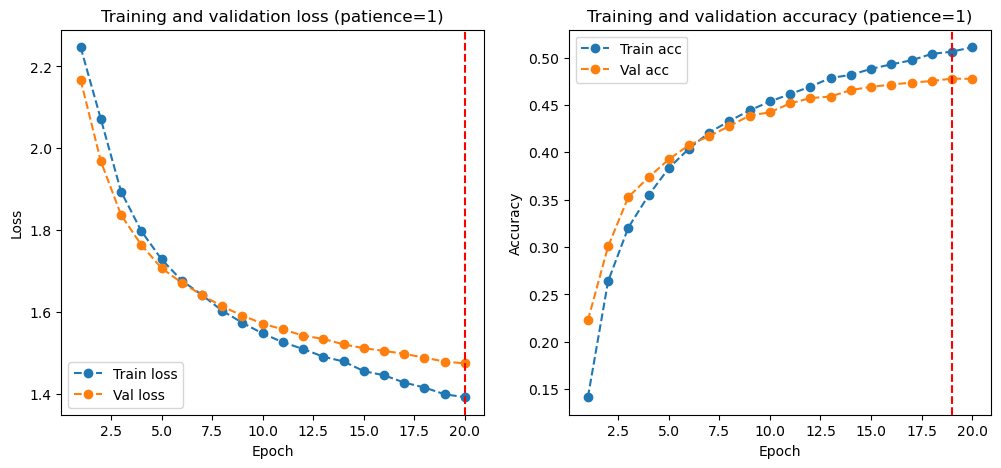

In [72]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o--', label="Train loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, 'o--', label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss (patience=1)")
plt.legend()
plt.axvline(x=best_val_loss_epoch, color='r', linestyle='--', label='Best Val Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'o--', label="Train acc")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'o--', label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy (patience=1)")
plt.legend()
plt.axvline(x=best_val_acc_epoch, color='r', linestyle='--', label='Best Val Acc')

plt.show()

#### TODO:
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- Implement a patience functionality into `EarlyStopper`: stop model training, if validation accuracy did not increase for `patience` epochs. You are allowed to add more arguments to `EarlyStopper.__init__`.
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

In [66]:
class EarlyStopper:
    """Early stops the training if validation accuracy does not increase after a
    given patience. Saves and loads model checkpoints.
    """
    def __init__(self, verbose=False, path='checkpoint.pt', patience=1):
        """Initialization.

        Args:
            verbose (bool, optional): Print additional information. Defaults to False.
            path (str, optional): Path where checkpoints should be saved. 
                Defaults to 'checkpoint.pt'.
            patience (int, optional): Number of epochs to wait for increasing
                accuracy. If accuracy does not increase, stop training early. 
                Defaults to 1.
        """
        self.verbose = verbose
        self.path = path
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = float('-inf')

    def update(self, val_acc, model):
        """Call after each epoch of model training to update early stopper object.

        Args:
            val_acc (float): Accuracy on validation set
            model (nn.Module): torch model that is trained
        """
        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model, val_acc)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:    # If verbose = True, print the counter 
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model, val_acc)
            self.counter = 0

    def save_checkpoint(self, model, val_acc):
        """Save model checkpoint.

        Args:
            model (nn.Module): Model of which parameters should be saved.
        """
        if self.verbose:
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc

    def load_checkpoint(self, model):
        """Load model from checkpoint.

        Args:
            model (nn.Module): Model that should be reset to parameters loaded
                from checkpoint.

        Returns:
            nn.Module: Model with parameters from checkpoint
        """
        model.load_state_dict(torch.load(self.path))
        return model


Training with patience = 1


Learning rate: 0.0001, Epoch: 1, Train loss: 2.25, Val loss: 2.17, Train acc: 0.141, Val acc: 0.223
Validation accuracy increased (-inf --> 0.222600).  Saving model ...


Learning rate: 0.0001, Epoch: 2, Train loss: 2.07, Val loss: 1.97, Train acc: 0.264, Val acc: 0.301
Validation accuracy increased (0.222600 --> 0.300700).  Saving model ...


Learning rate: 0.0001, Epoch: 3, Train loss: 1.89, Val loss: 1.84, Train acc: 0.321, Val acc: 0.353
Validation accuracy increased (0.300700 --> 0.352800).  Saving model ...


Learning rate: 0.0001, Epoch: 4, Train loss: 1.80, Val loss: 1.76, Train acc: 0.355, Val acc: 0.374
Validation accuracy increased (0.352800 --> 0.373600).  Saving model ...


Learning rate: 0.0001, Epoch: 5, Train loss: 1.73, Val loss: 1.71, Train acc: 0.383, Val acc: 0.393
Validation accuracy increased (0.373600 --> 0.392500).  Saving model ...


Learning rate: 0.0001, Epoch: 6, Train loss: 1.68, Val loss: 1.67, Train acc: 0.404, Val acc: 0.408
Validation accuracy increased (0.392500 --> 0.407700).  Saving model ...


Learning rate: 0.0001, Epoch: 7, Train loss: 1.64, Val loss: 1.64, Train acc: 0.421, Val acc: 0.417
Validation accuracy increased (0.407700 --> 0.417100).  Saving model ...


Learning rate: 0.0001, Epoch: 8, Train loss: 1.60, Val loss: 1.61, Train acc: 0.433, Val acc: 0.428
Validation accuracy increased (0.417100 --> 0.427700).  Saving model ...


Learning rate: 0.0001, Epoch: 9, Train loss: 1.57, Val loss: 1.59, Train acc: 0.444, Val acc: 0.439
Validation accuracy increased (0.427700 --> 0.438800).  Saving model ...


Learning rate: 0.0001, Epoch: 10, Train loss: 1.55, Val loss: 1.57, Train acc: 0.454, Val acc: 0.442
Validation accuracy increased (0.438800 --> 0.442200).  Saving model ...


Learning rate: 0.0001, Epoch: 11, Train loss: 1.53, Val loss: 1.56, Train acc: 0.461, Val acc: 0.452
Validation accuracy increased (0.442200 --> 0.451700).  Saving model ...


Learning rate: 0.0001, Epoch: 12, Train loss: 1.51, Val loss: 1.54, Train acc: 0.469, Val acc: 0.457
Validation accuracy increased (0.451700 --> 0.457200).  Saving model ...


Learning rate: 0.0001, Epoch: 13, Train loss: 1.49, Val loss: 1.53, Train acc: 0.478, Val acc: 0.459
Validation accuracy increased (0.457200 --> 0.458900).  Saving model ...


Learning rate: 0.0001, Epoch: 14, Train loss: 1.48, Val loss: 1.52, Train acc: 0.482, Val acc: 0.466
Validation accuracy increased (0.458900 --> 0.465700).  Saving model ...


Learning rate: 0.0001, Epoch: 15, Train loss: 1.46, Val loss: 1.51, Train acc: 0.488, Val acc: 0.469
Validation accuracy increased (0.465700 --> 0.469100).  Saving model ...


Learning rate: 0.0001, Epoch: 16, Train loss: 1.45, Val loss: 1.50, Train acc: 0.493, Val acc: 0.471
Validation accuracy increased (0.469100 --> 0.471500).  Saving model ...


Learning rate: 0.0001, Epoch: 17, Train loss: 1.43, Val loss: 1.50, Train acc: 0.497, Val acc: 0.474
Validation accuracy increased (0.471500 --> 0.473600).  Saving model ...


Learning rate: 0.0001, Epoch: 18, Train loss: 1.42, Val loss: 1.49, Train acc: 0.504, Val acc: 0.475
Validation accuracy increased (0.473600 --> 0.475200).  Saving model ...


Learning rate: 0.0001, Epoch: 19, Train loss: 1.40, Val loss: 1.48, Train acc: 0.506, Val acc: 0.478
Validation accuracy increased (0.475200 --> 0.477800).  Saving model ...


Learning rate: 0.0001, Epoch: 20, Train loss: 1.39, Val loss: 1.47, Train acc: 0.511, Val acc: 0.477
EarlyStopping counter: 1 out of 1
Early stopping
Best validation loss: 1.4745 at epoch 20
Best validation accuracy: 0.4778 at epoch 19


/tmp/ipykernel_2579050/4103543973.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.path))


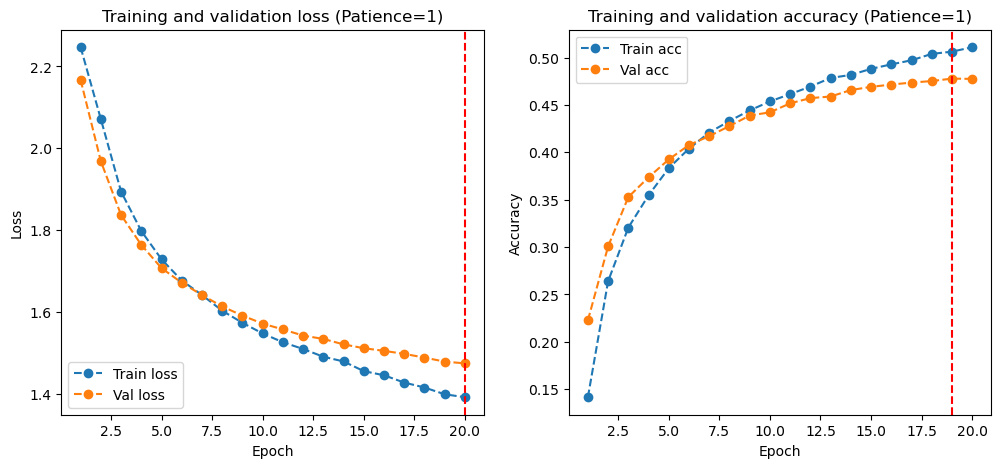


Training with patience = 2


Learning rate: 0.0001, Epoch: 1, Train loss: 2.25, Val loss: 2.17, Train acc: 0.141, Val acc: 0.223
Validation accuracy increased (-inf --> 0.222600).  Saving model ...


Learning rate: 0.0001, Epoch: 2, Train loss: 2.07, Val loss: 1.97, Train acc: 0.264, Val acc: 0.301
Validation accuracy increased (0.222600 --> 0.300700).  Saving model ...


Learning rate: 0.0001, Epoch: 3, Train loss: 1.89, Val loss: 1.84, Train acc: 0.321, Val acc: 0.353
Validation accuracy increased (0.300700 --> 0.352800).  Saving model ...


Learning rate: 0.0001, Epoch: 4, Train loss: 1.80, Val loss: 1.76, Train acc: 0.355, Val acc: 0.374
Validation accuracy increased (0.352800 --> 0.373600).  Saving model ...


Learning rate: 0.0001, Epoch: 5, Train loss: 1.73, Val loss: 1.71, Train acc: 0.383, Val acc: 0.393
Validation accuracy increased (0.373600 --> 0.392500).  Saving model ...


Learning rate: 0.0001, Epoch: 6, Train loss: 1.68, Val loss: 1.67, Train acc: 0.404, Val acc: 0.408
Validation accuracy increased (0.392500 --> 0.407700).  Saving model ...


Learning rate: 0.0001, Epoch: 7, Train loss: 1.64, Val loss: 1.64, Train acc: 0.421, Val acc: 0.417
Validation accuracy increased (0.407700 --> 0.417100).  Saving model ...


Learning rate: 0.0001, Epoch: 8, Train loss: 1.60, Val loss: 1.61, Train acc: 0.433, Val acc: 0.428
Validation accuracy increased (0.417100 --> 0.427700).  Saving model ...


Learning rate: 0.0001, Epoch: 9, Train loss: 1.57, Val loss: 1.59, Train acc: 0.444, Val acc: 0.439
Validation accuracy increased (0.427700 --> 0.438800).  Saving model ...


Learning rate: 0.0001, Epoch: 10, Train loss: 1.55, Val loss: 1.57, Train acc: 0.454, Val acc: 0.442
Validation accuracy increased (0.438800 --> 0.442200).  Saving model ...


Learning rate: 0.0001, Epoch: 11, Train loss: 1.53, Val loss: 1.56, Train acc: 0.461, Val acc: 0.452
Validation accuracy increased (0.442200 --> 0.451700).  Saving model ...


Learning rate: 0.0001, Epoch: 12, Train loss: 1.51, Val loss: 1.54, Train acc: 0.469, Val acc: 0.457
Validation accuracy increased (0.451700 --> 0.457200).  Saving model ...


Learning rate: 0.0001, Epoch: 13, Train loss: 1.49, Val loss: 1.53, Train acc: 0.478, Val acc: 0.459
Validation accuracy increased (0.457200 --> 0.458900).  Saving model ...


Learning rate: 0.0001, Epoch: 14, Train loss: 1.48, Val loss: 1.52, Train acc: 0.482, Val acc: 0.466
Validation accuracy increased (0.458900 --> 0.465700).  Saving model ...


Learning rate: 0.0001, Epoch: 15, Train loss: 1.46, Val loss: 1.51, Train acc: 0.488, Val acc: 0.469
Validation accuracy increased (0.465700 --> 0.469100).  Saving model ...


Learning rate: 0.0001, Epoch: 16, Train loss: 1.45, Val loss: 1.50, Train acc: 0.493, Val acc: 0.471
Validation accuracy increased (0.469100 --> 0.471500).  Saving model ...


Learning rate: 0.0001, Epoch: 17, Train loss: 1.43, Val loss: 1.50, Train acc: 0.497, Val acc: 0.474
Validation accuracy increased (0.471500 --> 0.473600).  Saving model ...


Learning rate: 0.0001, Epoch: 18, Train loss: 1.42, Val loss: 1.49, Train acc: 0.504, Val acc: 0.475
Validation accuracy increased (0.473600 --> 0.475200).  Saving model ...


Learning rate: 0.0001, Epoch: 19, Train loss: 1.40, Val loss: 1.48, Train acc: 0.506, Val acc: 0.478
Validation accuracy increased (0.475200 --> 0.477800).  Saving model ...


Learning rate: 0.0001, Epoch: 20, Train loss: 1.39, Val loss: 1.47, Train acc: 0.511, Val acc: 0.477
EarlyStopping counter: 1 out of 2


Learning rate: 0.0001, Epoch: 21, Train loss: 1.38, Val loss: 1.47, Train acc: 0.514, Val acc: 0.481
Validation accuracy increased (0.477800 --> 0.481300).  Saving model ...


Learning rate: 0.0001, Epoch: 22, Train loss: 1.37, Val loss: 1.47, Train acc: 0.518, Val acc: 0.481
Validation accuracy increased (0.481300 --> 0.481400).  Saving model ...


Learning rate: 0.0001, Epoch: 23, Train loss: 1.35, Val loss: 1.46, Train acc: 0.523, Val acc: 0.486
Validation accuracy increased (0.481400 --> 0.486400).  Saving model ...


Learning rate: 0.0001, Epoch: 24, Train loss: 1.34, Val loss: 1.45, Train acc: 0.526, Val acc: 0.485
EarlyStopping counter: 1 out of 2


Learning rate: 0.0001, Epoch: 25, Train loss: 1.34, Val loss: 1.45, Train acc: 0.531, Val acc: 0.491
Validation accuracy increased (0.486400 --> 0.491000).  Saving model ...


Learning rate: 0.0001, Epoch: 26, Train loss: 1.32, Val loss: 1.44, Train acc: 0.535, Val acc: 0.494
Validation accuracy increased (0.491000 --> 0.493600).  Saving model ...


Learning rate: 0.0001, Epoch: 27, Train loss: 1.31, Val loss: 1.44, Train acc: 0.537, Val acc: 0.494
Validation accuracy increased (0.493600 --> 0.493900).  Saving model ...


Learning rate: 0.0001, Epoch: 28, Train loss: 1.30, Val loss: 1.44, Train acc: 0.541, Val acc: 0.496
Validation accuracy increased (0.493900 --> 0.495900).  Saving model ...


Learning rate: 0.0001, Epoch: 29, Train loss: 1.30, Val loss: 1.44, Train acc: 0.543, Val acc: 0.495
EarlyStopping counter: 1 out of 2


Learning rate: 0.0001, Epoch: 30, Train loss: 1.28, Val loss: 1.43, Train acc: 0.546, Val acc: 0.499
Validation accuracy increased (0.495900 --> 0.498800).  Saving model ...


Learning rate: 0.0001, Epoch: 31, Train loss: 1.26, Val loss: 1.42, Train acc: 0.550, Val acc: 0.498
EarlyStopping counter: 1 out of 2


Learning rate: 0.0001, Epoch: 32, Train loss: 1.26, Val loss: 1.43, Train acc: 0.555, Val acc: 0.499
Validation accuracy increased (0.498800 --> 0.498900).  Saving model ...


Learning rate: 0.0001, Epoch: 33, Train loss: 1.25, Val loss: 1.43, Train acc: 0.557, Val acc: 0.499
Validation accuracy increased (0.498900 --> 0.499400).  Saving model ...


Learning rate: 0.0001, Epoch: 34, Train loss: 1.24, Val loss: 1.42, Train acc: 0.561, Val acc: 0.501
Validation accuracy increased (0.499400 --> 0.500900).  Saving model ...


Learning rate: 0.0001, Epoch: 35, Train loss: 1.24, Val loss: 1.42, Train acc: 0.565, Val acc: 0.502
Validation accuracy increased (0.500900 --> 0.502100).  Saving model ...


Learning rate: 0.0001, Epoch: 36, Train loss: 1.23, Val loss: 1.42, Train acc: 0.566, Val acc: 0.503
Validation accuracy increased (0.502100 --> 0.503000).  Saving model ...


Learning rate: 0.0001, Epoch: 37, Train loss: 1.23, Val loss: 1.42, Train acc: 0.569, Val acc: 0.505
Validation accuracy increased (0.503000 --> 0.505500).  Saving model ...


Learning rate: 0.0001, Epoch: 38, Train loss: 1.21, Val loss: 1.41, Train acc: 0.572, Val acc: 0.502
EarlyStopping counter: 1 out of 2


Learning rate: 0.0001, Epoch: 39, Train loss: 1.20, Val loss: 1.41, Train acc: 0.577, Val acc: 0.505
EarlyStopping counter: 2 out of 2
Early stopping
Best validation loss: 1.4118 at epoch 39
Best validation accuracy: 0.5055 at epoch 37


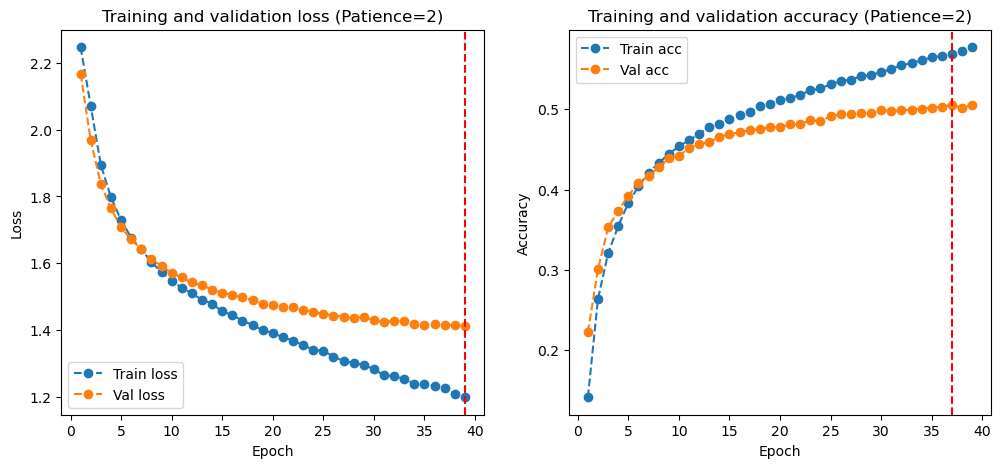


Training with patience = 5


Learning rate: 0.0001, Epoch: 1, Train loss: 2.25, Val loss: 2.17, Train acc: 0.141, Val acc: 0.223
Validation accuracy increased (-inf --> 0.222600).  Saving model ...


Learning rate: 0.0001, Epoch: 2, Train loss: 2.07, Val loss: 1.97, Train acc: 0.264, Val acc: 0.301
Validation accuracy increased (0.222600 --> 0.300700).  Saving model ...


Learning rate: 0.0001, Epoch: 3, Train loss: 1.89, Val loss: 1.84, Train acc: 0.321, Val acc: 0.353
Validation accuracy increased (0.300700 --> 0.352800).  Saving model ...


Learning rate: 0.0001, Epoch: 4, Train loss: 1.80, Val loss: 1.76, Train acc: 0.355, Val acc: 0.374
Validation accuracy increased (0.352800 --> 0.373600).  Saving model ...


Learning rate: 0.0001, Epoch: 5, Train loss: 1.73, Val loss: 1.71, Train acc: 0.383, Val acc: 0.393
Validation accuracy increased (0.373600 --> 0.392500).  Saving model ...


Learning rate: 0.0001, Epoch: 6, Train loss: 1.68, Val loss: 1.67, Train acc: 0.404, Val acc: 0.408
Validation accuracy increased (0.392500 --> 0.407700).  Saving model ...


Learning rate: 0.0001, Epoch: 7, Train loss: 1.64, Val loss: 1.64, Train acc: 0.421, Val acc: 0.417
Validation accuracy increased (0.407700 --> 0.417100).  Saving model ...


Learning rate: 0.0001, Epoch: 8, Train loss: 1.60, Val loss: 1.61, Train acc: 0.433, Val acc: 0.428
Validation accuracy increased (0.417100 --> 0.427700).  Saving model ...


Learning rate: 0.0001, Epoch: 9, Train loss: 1.57, Val loss: 1.59, Train acc: 0.444, Val acc: 0.439
Validation accuracy increased (0.427700 --> 0.438800).  Saving model ...


Learning rate: 0.0001, Epoch: 10, Train loss: 1.55, Val loss: 1.57, Train acc: 0.454, Val acc: 0.442
Validation accuracy increased (0.438800 --> 0.442200).  Saving model ...


Learning rate: 0.0001, Epoch: 11, Train loss: 1.53, Val loss: 1.56, Train acc: 0.461, Val acc: 0.452
Validation accuracy increased (0.442200 --> 0.451700).  Saving model ...


Learning rate: 0.0001, Epoch: 12, Train loss: 1.51, Val loss: 1.54, Train acc: 0.469, Val acc: 0.457
Validation accuracy increased (0.451700 --> 0.457200).  Saving model ...


Learning rate: 0.0001, Epoch: 13, Train loss: 1.49, Val loss: 1.53, Train acc: 0.478, Val acc: 0.459
Validation accuracy increased (0.457200 --> 0.458900).  Saving model ...


Learning rate: 0.0001, Epoch: 14, Train loss: 1.48, Val loss: 1.52, Train acc: 0.482, Val acc: 0.466
Validation accuracy increased (0.458900 --> 0.465700).  Saving model ...


Learning rate: 0.0001, Epoch: 15, Train loss: 1.46, Val loss: 1.51, Train acc: 0.488, Val acc: 0.469
Validation accuracy increased (0.465700 --> 0.469100).  Saving model ...


Learning rate: 0.0001, Epoch: 16, Train loss: 1.45, Val loss: 1.50, Train acc: 0.493, Val acc: 0.471
Validation accuracy increased (0.469100 --> 0.471500).  Saving model ...


Learning rate: 0.0001, Epoch: 17, Train loss: 1.43, Val loss: 1.50, Train acc: 0.497, Val acc: 0.474
Validation accuracy increased (0.471500 --> 0.473600).  Saving model ...


Learning rate: 0.0001, Epoch: 18, Train loss: 1.42, Val loss: 1.49, Train acc: 0.504, Val acc: 0.475
Validation accuracy increased (0.473600 --> 0.475200).  Saving model ...


Learning rate: 0.0001, Epoch: 19, Train loss: 1.40, Val loss: 1.48, Train acc: 0.506, Val acc: 0.478
Validation accuracy increased (0.475200 --> 0.477800).  Saving model ...


Learning rate: 0.0001, Epoch: 20, Train loss: 1.39, Val loss: 1.47, Train acc: 0.511, Val acc: 0.477
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 21, Train loss: 1.38, Val loss: 1.47, Train acc: 0.514, Val acc: 0.481
Validation accuracy increased (0.477800 --> 0.481300).  Saving model ...


Learning rate: 0.0001, Epoch: 22, Train loss: 1.37, Val loss: 1.47, Train acc: 0.518, Val acc: 0.481
Validation accuracy increased (0.481300 --> 0.481400).  Saving model ...


Learning rate: 0.0001, Epoch: 23, Train loss: 1.35, Val loss: 1.46, Train acc: 0.523, Val acc: 0.486
Validation accuracy increased (0.481400 --> 0.486400).  Saving model ...


Learning rate: 0.0001, Epoch: 24, Train loss: 1.34, Val loss: 1.45, Train acc: 0.526, Val acc: 0.485
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 25, Train loss: 1.34, Val loss: 1.45, Train acc: 0.531, Val acc: 0.491
Validation accuracy increased (0.486400 --> 0.491000).  Saving model ...


Learning rate: 0.0001, Epoch: 26, Train loss: 1.32, Val loss: 1.44, Train acc: 0.535, Val acc: 0.494
Validation accuracy increased (0.491000 --> 0.493600).  Saving model ...


Learning rate: 0.0001, Epoch: 27, Train loss: 1.31, Val loss: 1.44, Train acc: 0.537, Val acc: 0.494
Validation accuracy increased (0.493600 --> 0.493900).  Saving model ...


Learning rate: 0.0001, Epoch: 28, Train loss: 1.30, Val loss: 1.44, Train acc: 0.541, Val acc: 0.496
Validation accuracy increased (0.493900 --> 0.495900).  Saving model ...


Learning rate: 0.0001, Epoch: 29, Train loss: 1.30, Val loss: 1.44, Train acc: 0.543, Val acc: 0.495
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 30, Train loss: 1.28, Val loss: 1.43, Train acc: 0.546, Val acc: 0.499
Validation accuracy increased (0.495900 --> 0.498800).  Saving model ...


Learning rate: 0.0001, Epoch: 31, Train loss: 1.26, Val loss: 1.42, Train acc: 0.550, Val acc: 0.498
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 32, Train loss: 1.26, Val loss: 1.43, Train acc: 0.555, Val acc: 0.499
Validation accuracy increased (0.498800 --> 0.498900).  Saving model ...


Learning rate: 0.0001, Epoch: 33, Train loss: 1.25, Val loss: 1.43, Train acc: 0.557, Val acc: 0.499
Validation accuracy increased (0.498900 --> 0.499400).  Saving model ...


Learning rate: 0.0001, Epoch: 34, Train loss: 1.24, Val loss: 1.42, Train acc: 0.561, Val acc: 0.501
Validation accuracy increased (0.499400 --> 0.500900).  Saving model ...


Learning rate: 0.0001, Epoch: 35, Train loss: 1.24, Val loss: 1.42, Train acc: 0.565, Val acc: 0.502
Validation accuracy increased (0.500900 --> 0.502100).  Saving model ...


Learning rate: 0.0001, Epoch: 36, Train loss: 1.23, Val loss: 1.42, Train acc: 0.566, Val acc: 0.503
Validation accuracy increased (0.502100 --> 0.503000).  Saving model ...


Learning rate: 0.0001, Epoch: 37, Train loss: 1.23, Val loss: 1.42, Train acc: 0.569, Val acc: 0.505
Validation accuracy increased (0.503000 --> 0.505500).  Saving model ...


Learning rate: 0.0001, Epoch: 38, Train loss: 1.21, Val loss: 1.41, Train acc: 0.572, Val acc: 0.502
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 39, Train loss: 1.20, Val loss: 1.41, Train acc: 0.577, Val acc: 0.505
EarlyStopping counter: 2 out of 5


Learning rate: 0.0001, Epoch: 40, Train loss: 1.19, Val loss: 1.41, Train acc: 0.579, Val acc: 0.506
Validation accuracy increased (0.505500 --> 0.505900).  Saving model ...


Learning rate: 0.0001, Epoch: 41, Train loss: 1.18, Val loss: 1.41, Train acc: 0.583, Val acc: 0.507
Validation accuracy increased (0.505900 --> 0.507300).  Saving model ...


Learning rate: 0.0001, Epoch: 42, Train loss: 1.18, Val loss: 1.41, Train acc: 0.585, Val acc: 0.504
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 43, Train loss: 1.17, Val loss: 1.42, Train acc: 0.588, Val acc: 0.503
EarlyStopping counter: 2 out of 5


Learning rate: 0.0001, Epoch: 44, Train loss: 1.16, Val loss: 1.41, Train acc: 0.592, Val acc: 0.510
Validation accuracy increased (0.507300 --> 0.510100).  Saving model ...


Learning rate: 0.0001, Epoch: 45, Train loss: 1.15, Val loss: 1.41, Train acc: 0.593, Val acc: 0.509
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 46, Train loss: 1.15, Val loss: 1.41, Train acc: 0.596, Val acc: 0.509
EarlyStopping counter: 2 out of 5


Learning rate: 0.0001, Epoch: 47, Train loss: 1.14, Val loss: 1.41, Train acc: 0.598, Val acc: 0.510
EarlyStopping counter: 3 out of 5


Learning rate: 0.0001, Epoch: 48, Train loss: 1.13, Val loss: 1.41, Train acc: 0.600, Val acc: 0.511
Validation accuracy increased (0.510100 --> 0.510700).  Saving model ...


Learning rate: 0.0001, Epoch: 49, Train loss: 1.13, Val loss: 1.41, Train acc: 0.604, Val acc: 0.508
EarlyStopping counter: 1 out of 5


Learning rate: 0.0001, Epoch: 50, Train loss: 1.12, Val loss: 1.41, Train acc: 0.606, Val acc: 0.507
EarlyStopping counter: 2 out of 5


Learning rate: 0.0001, Epoch: 51, Train loss: 1.11, Val loss: 1.41, Train acc: 0.608, Val acc: 0.508
EarlyStopping counter: 3 out of 5


Learning rate: 0.0001, Epoch: 52, Train loss: 1.11, Val loss: 1.41, Train acc: 0.612, Val acc: 0.510
EarlyStopping counter: 4 out of 5


Learning rate: 0.0001, Epoch: 53, Train loss: 1.10, Val loss: 1.42, Train acc: 0.613, Val acc: 0.509
EarlyStopping counter: 5 out of 5
Early stopping
Best validation loss: 1.4055 at epoch 44
Best validation accuracy: 0.5107 at epoch 48


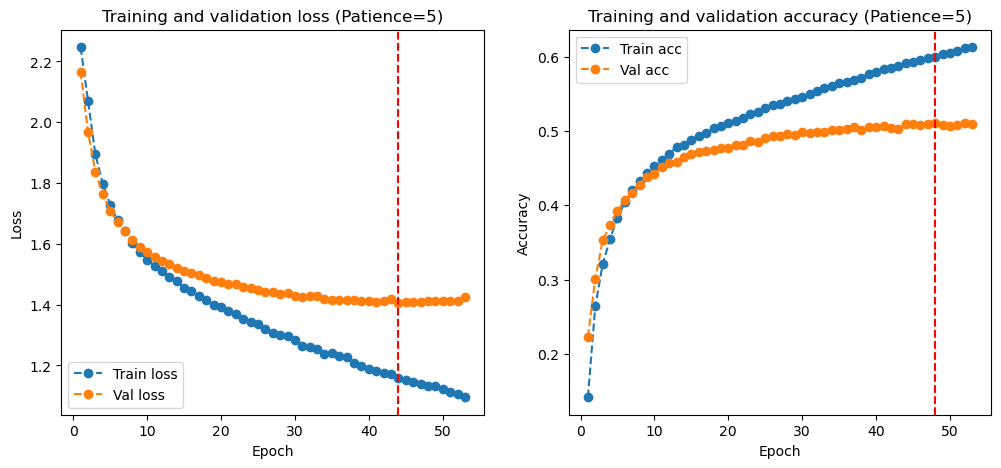

In [61]:
# Train the model with different patience values
patience_values = [1, 2, 5]

for patience in patience_values:
    print(f"\nTraining with patience = {patience}")
    
    # Set random seed for reproducibility
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)    # if multiple GPUs are available
    torch.backends.cudnn.deterministic = True   # if use cudnn
    torch.backends.cudnn.benchmark = False       # benchmark mode may be faster for fixed size input, but may be slower for varying input sizes

    # Instantiate the MLP model 
    model = MLP(img_width=32, num_in_channels=3, num_classes=10, num_hidden_units=100, num_hidden_layers=3, act_fn=nn.ReLU()).to(device)

    # Define the loss function 
    loss_fn = nn.CrossEntropyLoss()

    # Set the learning rate to 0.0001
    learning_rate = 0.0001

    # Define the optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize the EarlyStopper
    early_stopper = EarlyStopper(verbose=True, patience=patience)

    # Store training and validation losses and accuracies 
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Train the model for 100 epochs 
    num_epochs = 100
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train(trainloader, optimizer, model, loss_fn, device, None)
        val_loss, val_acc, _ = validate(valloader, model, loss_fn, device, None)

        # Store the losses and accuracies 
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f"Learning rate: {learning_rate}, Epoch: {epoch}, Train loss: {train_loss:.2f}, Val loss: {val_loss:.2f}, Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")

        # Update the early stopper 
        early_stopper.update(val_acc, model)
        
        # Check if early stopping criterion is met
        if early_stopper.early_stop:
            print("Early stopping")
            break    # Break the training loop if early stopping criterion is met

    # Load the best model
    model = early_stopper.load_checkpoint(model)

    # Find the best validation loss and accuracy 
    best_val_loss = min(val_losses)
    best_val_loss_epoch = val_losses.index(best_val_loss) + 1
    best_val_acc = max(val_accuracies)
    best_val_acc_epoch = val_accuracies.index(best_val_acc) + 1
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")
    print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")

    # Plot the training and validation losses and accuracies
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'o--', label="Train loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'o--', label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and validation loss (Patience={patience})")
    plt.legend()
    plt.axvline(x=best_val_loss_epoch, color='r', linestyle='--', label='Best Val Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'o--', label="Train acc")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'o--', label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Training and validation accuracy (Patience={patience})")
    plt.legend()
    plt.axvline(x=best_val_acc_epoch, color='r', linestyle='--', label='Best Val Acc')

    plt.show()

Best validation loss: 1.4055 at epoch 44
Best validation accuracy: 0.5107 at epoch 48


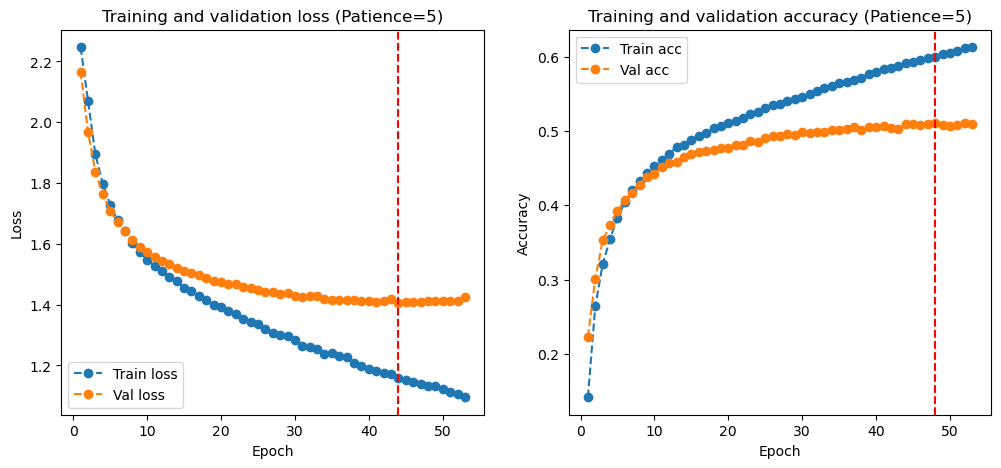

In [68]:
    # Find the best validation loss and accuracy 
    best_val_loss = min(val_losses)
    best_val_loss_epoch = val_losses.index(best_val_loss) + 1
    best_val_acc = max(val_accuracies)
    best_val_acc_epoch = val_accuracies.index(best_val_acc) + 1
    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_val_loss_epoch}")
    print(f"Best validation accuracy: {best_val_acc:.4f} at epoch {best_val_acc_epoch}")

    # Plot the training and validation losses and accuracies
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'o--', label="Train loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, 'o--', label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and validation loss (Patience={patience})")
    plt.legend()
    plt.axvline(x=best_val_loss_epoch, color='r', linestyle='--', label='Best Val Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'o--', label="Train acc")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'o--', label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Training and validation accuracy (Patience={patience})")
    plt.legend()
    plt.axvline(x=best_val_acc_epoch, color='r', linestyle='--', label='Best Val Acc')

    plt.show()

## Which learning rate is best?

Now that we have a learning strategy that works well, let us explore the effect of the learning rate on training and model performance.

#### TODO:
- Run training again as above, but with learning rate decreased by one order of magnitude, i.e. `lr = 1e-3`
- Run training again as above, but now with even smaller learning rate, `lr = 1e-4`
- What do you observe in terms of model accuracy? How long did it take to train these models? Which learning rate would you choose for any subsequent experiments you could do?

In [ ]:
lr = 1e-3

####################
## YOUR CODE HERE ##
####################

In [ ]:
lr = 1e-4

####################
## YOUR CODE HERE ##
####################

# What about the architecture?

How does architecture affect predictive performance? 

#### TODO:
In the following, try to improve model performance by varying 
- number of  hidden units
- number of layers

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy. 

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

In [ ]:
# number of hidden units

####################
## YOUR CODE HERE ##
####################

In [ ]:
# number of layers

####################
## YOUR CODE HERE ##
####################

#### Questions
- How good do you get?
- Which hyper-parameter makes the largest difference?
- Does it always help to make your model bigger (i.e. wider / deeper)? Why not?



**Your answers:**
- ...

Now, here are more TODO's, questions and a little challenge for you: 

#### TODO:
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?
    - When creating the exercise, I got a validation accuracy of 57%
    - Surpassing 50% val. acc. should be possible for you

In [ ]:
# Your best model:

####################
## YOUR CODE HERE ##
####################

#### Questions:
- If you train the same model multiple times from scratch: do you get the same performance? Are the models you trained above comparable then?
- What could we do about this?
    - *Hint:* there are actually multiple answers to this question. 
    - One could be to change model training and evaluation. How?
    - The other could be to use a more sophisticated analysis. How?

# Evaluate your best model on test set, once!

When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO:
- What is the accuracy of the best model you found on the test set?
- Plot the confusion matrix, too!

In [ ]:
def test(test_loader, model, device):
    """Compute accuracy and confusion matrix on test set.

    Args:
        test_loader (DataLoader): torch DataLoader of test set
        model (nn.Module): Model to evaluate on test set
        device (torch.device): Device to use

    Returns:
        float, torch.Tensor shape (10,10): Returns model accuracy on test set
            (percent classified correctly) and confusion matrix
    """
    ####################
    ## YOUR CODE HERE ##
    ####################

*Hint:* Use sklearn to create the confusion matrix ([link](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html))

In [ ]:
# The accuracy and confusion matrix

####################
## YOUR CODE HERE ##
####################

#### Questions:
- On which classes is your model's prediction poor?
- Is the test accuracy of your model as good as the validation accuracy?
- If those values are different: How can you explain the difference?
- Why should you never use test set performance when trying out different hyper-parameters and architectures?

## How about the optimizer? _(Optional)_

_This task is optional, you do not need to solve it_

Now let's check out what difference it makes to use different optimizers in the learning strategy and what effect it has on the performance.

#### TODO *(Optional)*:

- Run training of the same model used above with
    - different optimizers (_hint_ - https://pytorch.org/docs/stable/optim.html)
- Compare your training results of all the different optimizer settings from above.
- What is your observation while using different optimizers? What is the respective impact on the model performance?

In [ ]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

## Explore batch size *(Optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(Optional)*:
- Run training of the same model used above with 
    - batch size 1 for **one epoch**
    - batch size 512 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 and 1024 (from above)
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

*Hint*: You have to initialize new data loaders, as they provide you with batches during training.

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

In [ ]:
# Batch size 512

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

(OPTIONAL) You should evaluate on the test set with the optional solutions here (and see if they lead to performance gain).

In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials. You don't need to present the optional exercises

## Explore Activation Function _(Optional)_

*This task is optional, you do not need to solve it*

### TODO _(Optional)_:

Let's change activation function used (e.g. see [here](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity))
- Run training of the same model used above with a new activation function 
- Compare your training results

In [ ]:
###############################
## YOUR CODE HERE - OPTIONAL ##
###############################